# Topic Modelling

# Libraries

In [19]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np


# TOPIC MODELLING
from sklearn.feature_extraction.text import TfidfVectorizer
# NMF
from sklearn.decomposition import NMF
# LDA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# MDS
from sklearn.manifold import MDS
# VISUALIZATION
import matplotlib.pyplot as plt

# Data

In [20]:
C = pd.read_pickle("../output/C_for_NLP.pkl")

In [21]:
with open("../german_stopwords_plain.txt", "r") as f:
    stopwords = f.read().split("\n")
    stopwords = stopwords[9:] #licence

# remove punction r'[^\w\s]'
#C["eintrag_text"] = C["eintrag_text"].str.replace(r'[^\w\s]', '', regex=True)
C["eintrag_text_clean"] = C["eintrag_text_clean"].apply(lambda x: " ".join([word for word in x.split() if word.lower() not in stopwords]))

# TF-IDF

In [22]:
# min_df = 5 is good
tfidf_vectorizer = TfidfVectorizer(min_df = 5, ngram_range=(1,3), stop_words=stopwords)

tfidf_matrix = tfidf_vectorizer.fit_transform(C["eintrag_text_clean"])

feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index = C["header_id"])

#remove columns if they contain numbers
tfidf_df = tfidf_df.loc[:, ~tfidf_df.columns.str.contains(r'\d', regex=True)]
#remove columns with less than three characters
tfidf_df = tfidf_df.loc[:, tfidf_df.columns.str.len() > 2]
# remove "nan" from columns WHY IS IT EVEN THERE?
tfidf_df = tfidf_df.drop(columns = ["nan"])
display(tfidf_df.head())

C:\Users\N\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bsp', 'zb'] not in stop_words.
  warnings.warn(


abbildung  abbildung zeigt  abbildungen  \
header_id                                                                    
C1_facs_1_region_1699100518519_15        0.0              0.0          0.0   
C1_facs_2_region_1699101628768_50        0.0              0.0          0.0   
C1_facs_2_region_1699101668887_62        0.0              0.0          0.0   
C1_facs_3_region_1699102206352_41        0.0              0.0          0.0   
C1_facs_5_region_1699102766670_47        0.0              0.0          0.0   

                                   abbrechen  abbruch  abbruche  abel  \
header_id                                                               
C1_facs_1_region_1699100518519_15        0.0      0.0       0.0   0.0   
C1_facs_2_region_1699101628768_50        0.0      0.0       0.0   0.0   
C1_facs_2_region_1699101668887_62        0.0      0.0       0.0   0.0   
C1_facs_3_region_1699102206352_41        0.0      0.0       0.0   0.0   
C1_facs_5_region_1699102766670_47        0.0      0.0       0.0   0.0   

                                      abend  abende    abends  ...  \
header_id                                                      ...   
C1_facs_1_region_1699100518519_15  0.000000     0.0  0.000000  ...   
C1_facs_2_region_1699101628768_50  0.000000     0.0  0.000000  ...   
C1_facs_2_region_1699101668887_62  0.000000     0.0  0.000000  ...   
C1_facs_3_region_1699102206352_41  0.046533     0.0  0.039644  ...   
C1_facs_5_region_1699102766670_47  0.000000     0.0  0.000000  ...   

                                   überstandenen  übertraf  übertragen  \
header_id                                                                
C1_facs_1_region_1699100518519_15            0.0       0.0         0.0   
C1_facs_2_region_1699101628768_50            0.0       0.0         0.0   
C1_facs_2_region_1699101668887_62            0.0       0.0         0.0   
C1_facs_3_region_1699102206352_41            0.0       0.0         0.0   
C1_facs_5_region_1699102766670_47            0.0       0.0         0.0   

                                   übertreffen  übertrifft  übertrug  \
header_id                                                              
C1_facs_1_region_1699100518519_15          0.0         0.0       0.0   
C1_facs_2_region_1699101628768_50          0.0         0.0       0.0   
C1_facs_2_region_1699101668887_62          0.0         0.0       0.0   
C1_facs_3_region_1699102206352_41          0.0         0.0       0.0   
C1_facs_5_region_1699102766670_47          0.0         0.0       0.0   

                                   überzeugt  üblich  übrige  übrigen  
header_id                                                              
C1_facs_1_region_1699100518519_15        0.0     0.0     0.0      0.0  
C1_facs_2_region_1699101628768_50        0.0     0.0     0.0      0.0  
C1_facs_2_region_1699101668887_62        0.0     0.0     0.0      0.0  
C1_facs_3_region_1699102206352_41        0.0     0.0     0.0      0.0  
C1_facs_5_region_1699102766670_47        0.0     0.0     0.0      0.0  

[5 rows x 8126 columns]

In [23]:
tfidf_df.to_csv("../output/tfidf_df.csv")

# Topic Modelling

In [24]:
def plot_top_words(model, feature_names, n_top_words, title, n_documents_per_topic):
    """FROM https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py"""
    r, c = n_top_words//5, 5
    fig_h = n_top_words+5
    fig, axes = plt.subplots(r, c, figsize=(30, fig_h), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
            if topic_idx in n_documents_per_topic.index:
                top_features_ind = topic.argsort()[-n_top_words:]
                top_features = feature_names[top_features_ind]
                weights = topic[top_features_ind]
                ax = axes[topic_idx]
                ax.barh(top_features, weights, height=0.7)
                number_of_documents = n_documents_per_topic[topic_idx]
                ax.set_title(f"Topic {topic_idx +1} ({number_of_documents} entries)", fontdict={"fontsize": 30})
                ax.tick_params(axis="both", which="major", labelsize=20)
                for i in "top right left".split():
                    ax.spines[i].set_visible(False)
                fig.suptitle(title, fontsize=40)
        
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## NMF

In [25]:
n_topics = 10

nmf = NMF(n_components=n_topics, random_state=6452)

W = nmf.fit_transform( tfidf_df )
H = nmf.components_

W_df = pd.DataFrame(W, index=C["header_id"]) # documents x topics
H_df = pd.DataFrame(H, columns=tfidf_df.columns) # topics x words

display(W_df.head())
display(H_df.head())

0         1         2        3  \
header_id                                                                  
C1_facs_1_region_1699100518519_15  0.000943  0.000000  0.000000  0.00000   
C1_facs_2_region_1699101628768_50  0.000000  0.091607  0.000000  0.00000   
C1_facs_2_region_1699101668887_62  0.001550  0.014527  0.007641  0.00402   
C1_facs_3_region_1699102206352_41  0.036225  0.069819  0.000000  0.00020   
C1_facs_5_region_1699102766670_47  0.000000  0.111005  0.000000  0.00000   

                                          4         5         6         7  \
header_id                                                                   
C1_facs_1_region_1699100518519_15  0.000000  0.011117  0.093936  0.002683   
C1_facs_2_region_1699101628768_50  0.000000  0.000000  0.074328  0.000000   
C1_facs_2_region_1699101668887_62  0.000825  0.004687  0.053619  0.006697   
C1_facs_3_region_1699102206352_41  0.000000  0.039818  0.106255  0.003119   
C1_facs_5_region_1699102766670_47  0.000000  0.000543  0.015712  0.000000   

                                          8         9  
header_id                                              
C1_facs_1_region_1699100518519_15  0.033687  0.014809  
C1_facs_2_region_1699101628768_50  0.072655  0.032502  
C1_facs_2_region_1699101668887_62  0.013186  0.034442  
C1_facs_3_region_1699102206352_41  0.000000  0.006376  
C1_facs_5_region_1699102766670_47  0.123893  0.029292

abbildung  abbildung zeigt  abbildungen  abbrechen   abbruch  abbruche  \
0   0.000000         0.001716     0.000000   0.000000  0.001873  0.000000   
1   0.010624         0.000000     0.012217   0.002843  0.019650  0.022287   
2   0.005852         0.009010     0.001390   0.000000  0.007846  0.000000   
3   0.000892         0.000000     0.014094   0.000000  0.001161  0.000000   
4   0.034987         0.000000     0.016362   0.010716  0.000000  0.000000   

       abel     abend   abende    abends  ...  überstandenen  übertraf  \
0  0.000000  0.009304  0.00000  0.003352  ...       0.003102  0.004252   
1  0.000000  0.000000  0.00000  0.000000  ...       0.000608  0.000000   
2  0.000000  0.000000  0.00419  0.000000  ...       0.000000  0.014225   
3  0.000141  0.000000  0.00000  0.000000  ...       0.004348  0.002916   
4  0.001666  0.000000  0.00000  0.008996  ...       0.000000  0.000000   

   übertragen  übertreffen  übertrifft  übertrug  überzeugt    üblich  \
0    0.036590     0.000000    0.000000  0.026934   0.006112  0.008623   
1    0.000000     0.000000    0.003738  0.000000   0.000000  0.000000   
2    0.012443     0.015361    0.000000  0.016710   0.005792  0.001773   
3    0.021907     0.000097    0.000000  0.000000   0.000000  0.000000   
4    0.053859     0.000000    0.000000  0.010445   0.000000  0.000000   

     übrige   übrigen  
0  0.000000  0.015380  
1  0.000000  0.002968  
2  0.000000  0.000000  
3  0.003334  0.030960  
4  0.001804  0.041048  

[5 rows x 8126 columns]

In [26]:
W_df.to_csv("../output/doc_x_topic_df.csv")
H_df.to_csv("../output/topic_x_keyword_df.csv")

In [27]:
# document topic association with topic # and max value
topic_doc = pd.DataFrame([W_df.idxmax(axis=1), W_df.max(axis=1)]).T
topic_doc.columns = ["topic", "value"]
# find header_id in C
topic_doc = pd.merge(topic_doc, C[["header_id", "header_eintrag", "eintrag_text_clean"]], left_index=True, right_on="header_id")

In [29]:
topic_doc_vc = topic_doc["topic"].value_counts()

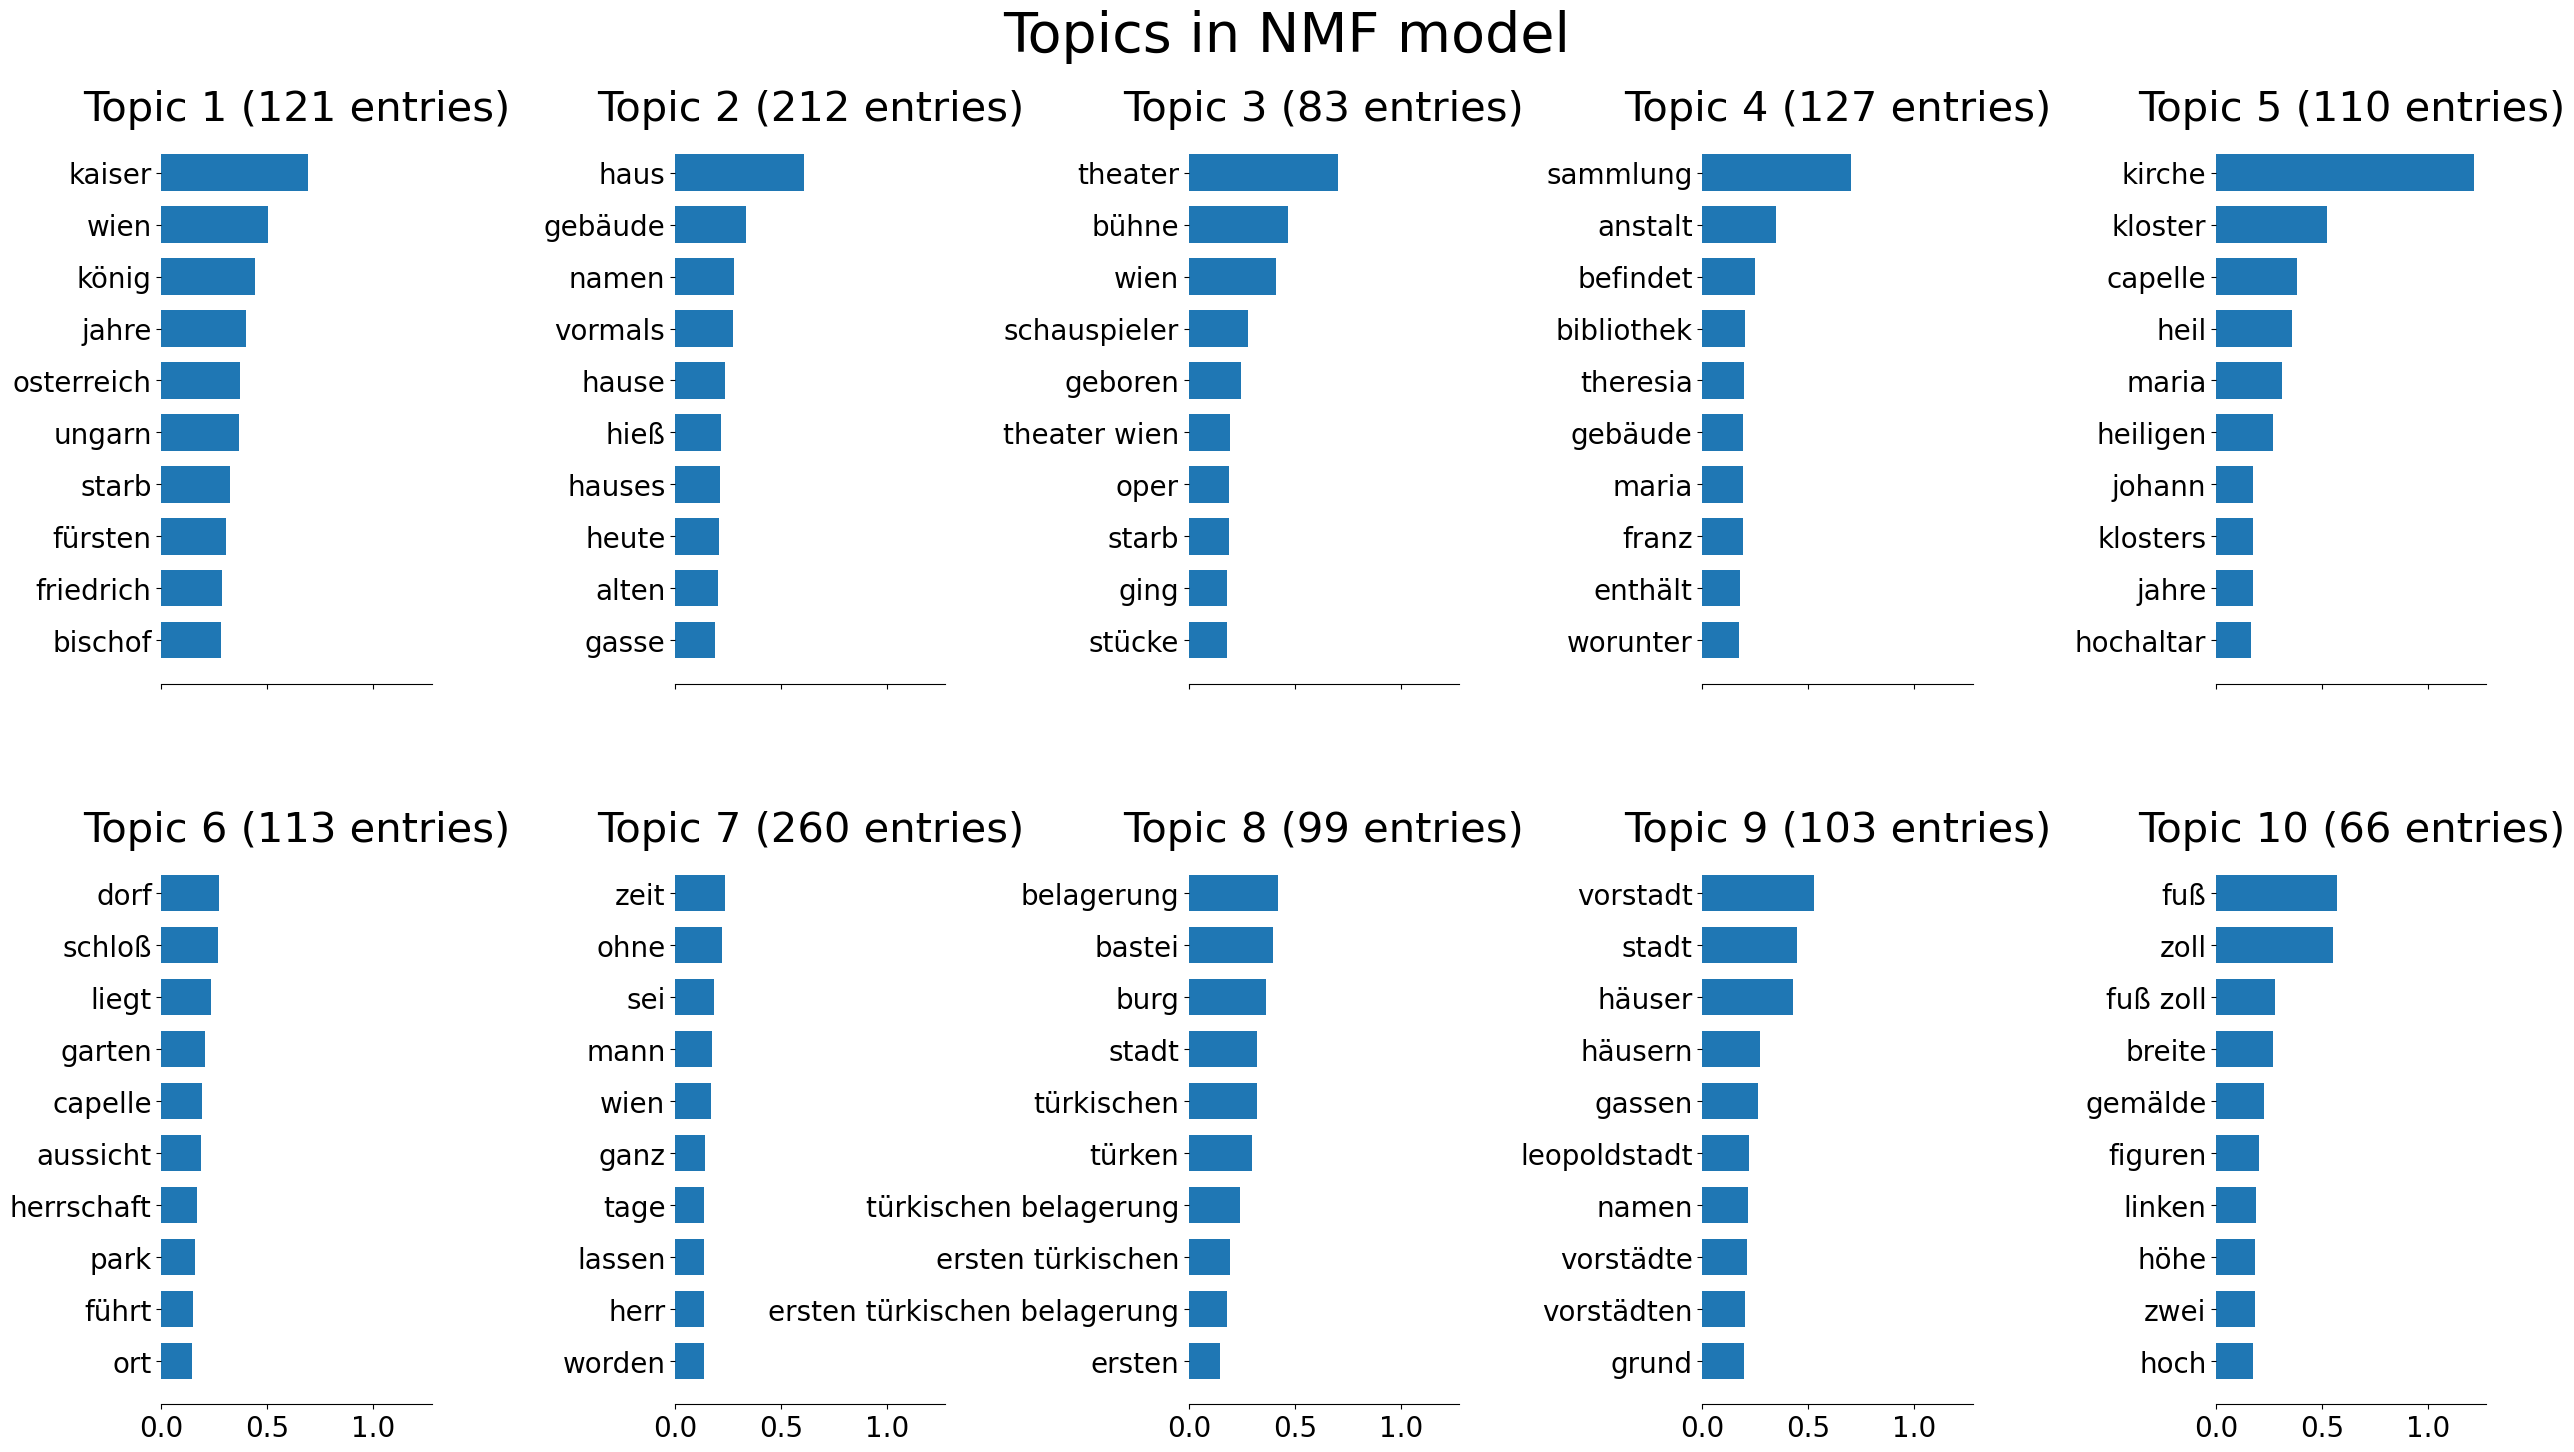

In [30]:
plot_top_words(nmf, tfidf_df.columns, n_topics, "Topics in NMF model", topic_doc_vc)

In [31]:
# group by topic and find the top 5 entries
max_topic_doc = topic_doc.groupby("topic").apply(lambda x: x.nlargest(5, "value")).reset_index(drop=True)

In [34]:
max_topic_doc.head()

topic     value                  header_id                  header_eintrag  \
0    0.0  0.184168  C1_facs_217_tr_1700431366              Bischöfe von Wien.   
1    0.0  0.165252  C1_facs_343_tr_1700432465                      Congresse.   
2    0.0  0.155823  C1_facs_446_tr_1700432173  Französischer König (in Wien).   
3    0.0  0.154187  C1_facs_333_tr_1700431827               Glesel (Melchior)   
4    0.0  0.133785  C1_facs_471_tr_1700430134   Gämperl (der Wiener Pfeifer).   

                                  eintrag_text_clean  
0  Bemühungen Fürsten Hause Babenberg römischen S...  
1  Wien Schauplatz zweier wich tiger, Geschicke O...  
2  Geschichte kennt Fall, König Frankreich Wien a...  
3  berühmte merkwürdige Mann Bäckerssohn Wien; El...  
4  König Andreas Ungarn, letzte Arpade, Venetiane...

In [35]:
topic_mapping = {0: "Courtly matters", 1: "Buildings", 2: "Culture", 3: "Culture / Theater?", 4: "Religion",
                5: "Suburbia", 6: "Entertainment?", 7: "Military? Bastions?", 8: "Suburbia", 9: "Paintigs (Art)"}

topic_doc["topic_name"] = topic_doc["topic"].map(topic_mapping)

In [42]:
topic_doc[['topic', 'value', 'topic_name', 'header_id', 'header_eintrag']].to_csv("../output/topic_doc.csv")

In [43]:
nmf_df = topic_doc.copy()

# TSNE

In [45]:
nmf_df.head()

topic     value                          header_id  \
0    6.0  0.093936  C1_facs_1_region_1699100518519_15   
1    1.0  0.091607  C1_facs_2_region_1699101628768_50   
2    6.0  0.053619  C1_facs_2_region_1699101668887_62   
3    6.0  0.106255  C1_facs_3_region_1699102206352_41   
4    8.0  0.123893  C1_facs_5_region_1699102766670_47   

                                      header_eintrag  \
0                                                  A   
1                                         AWOhäufer.   
2                                            Abaens.   
3  Abensperg= und Traunische (Gräf=\nlich=) Fidei...   
4                              Abgebrannte Haus (Das   

                                  eintrag_text_clean      topic_name  
0  enn große Stadt Ferne beschaut, lehren Wolken ...  Entertainment?  
1  gereicht gesunden Sinne Bewohner Wiens Ehre, d...       Buildings  
2  Abacus Bret Tisch, worauf vormals, Kopfrechner...  Entertainment?  
3  Herrngasse liegenden Häuser (240 241) gehören ...  Entertainment?  
4  Vorstadt Wieden (447) architektonisches Monstr...        Suburbia

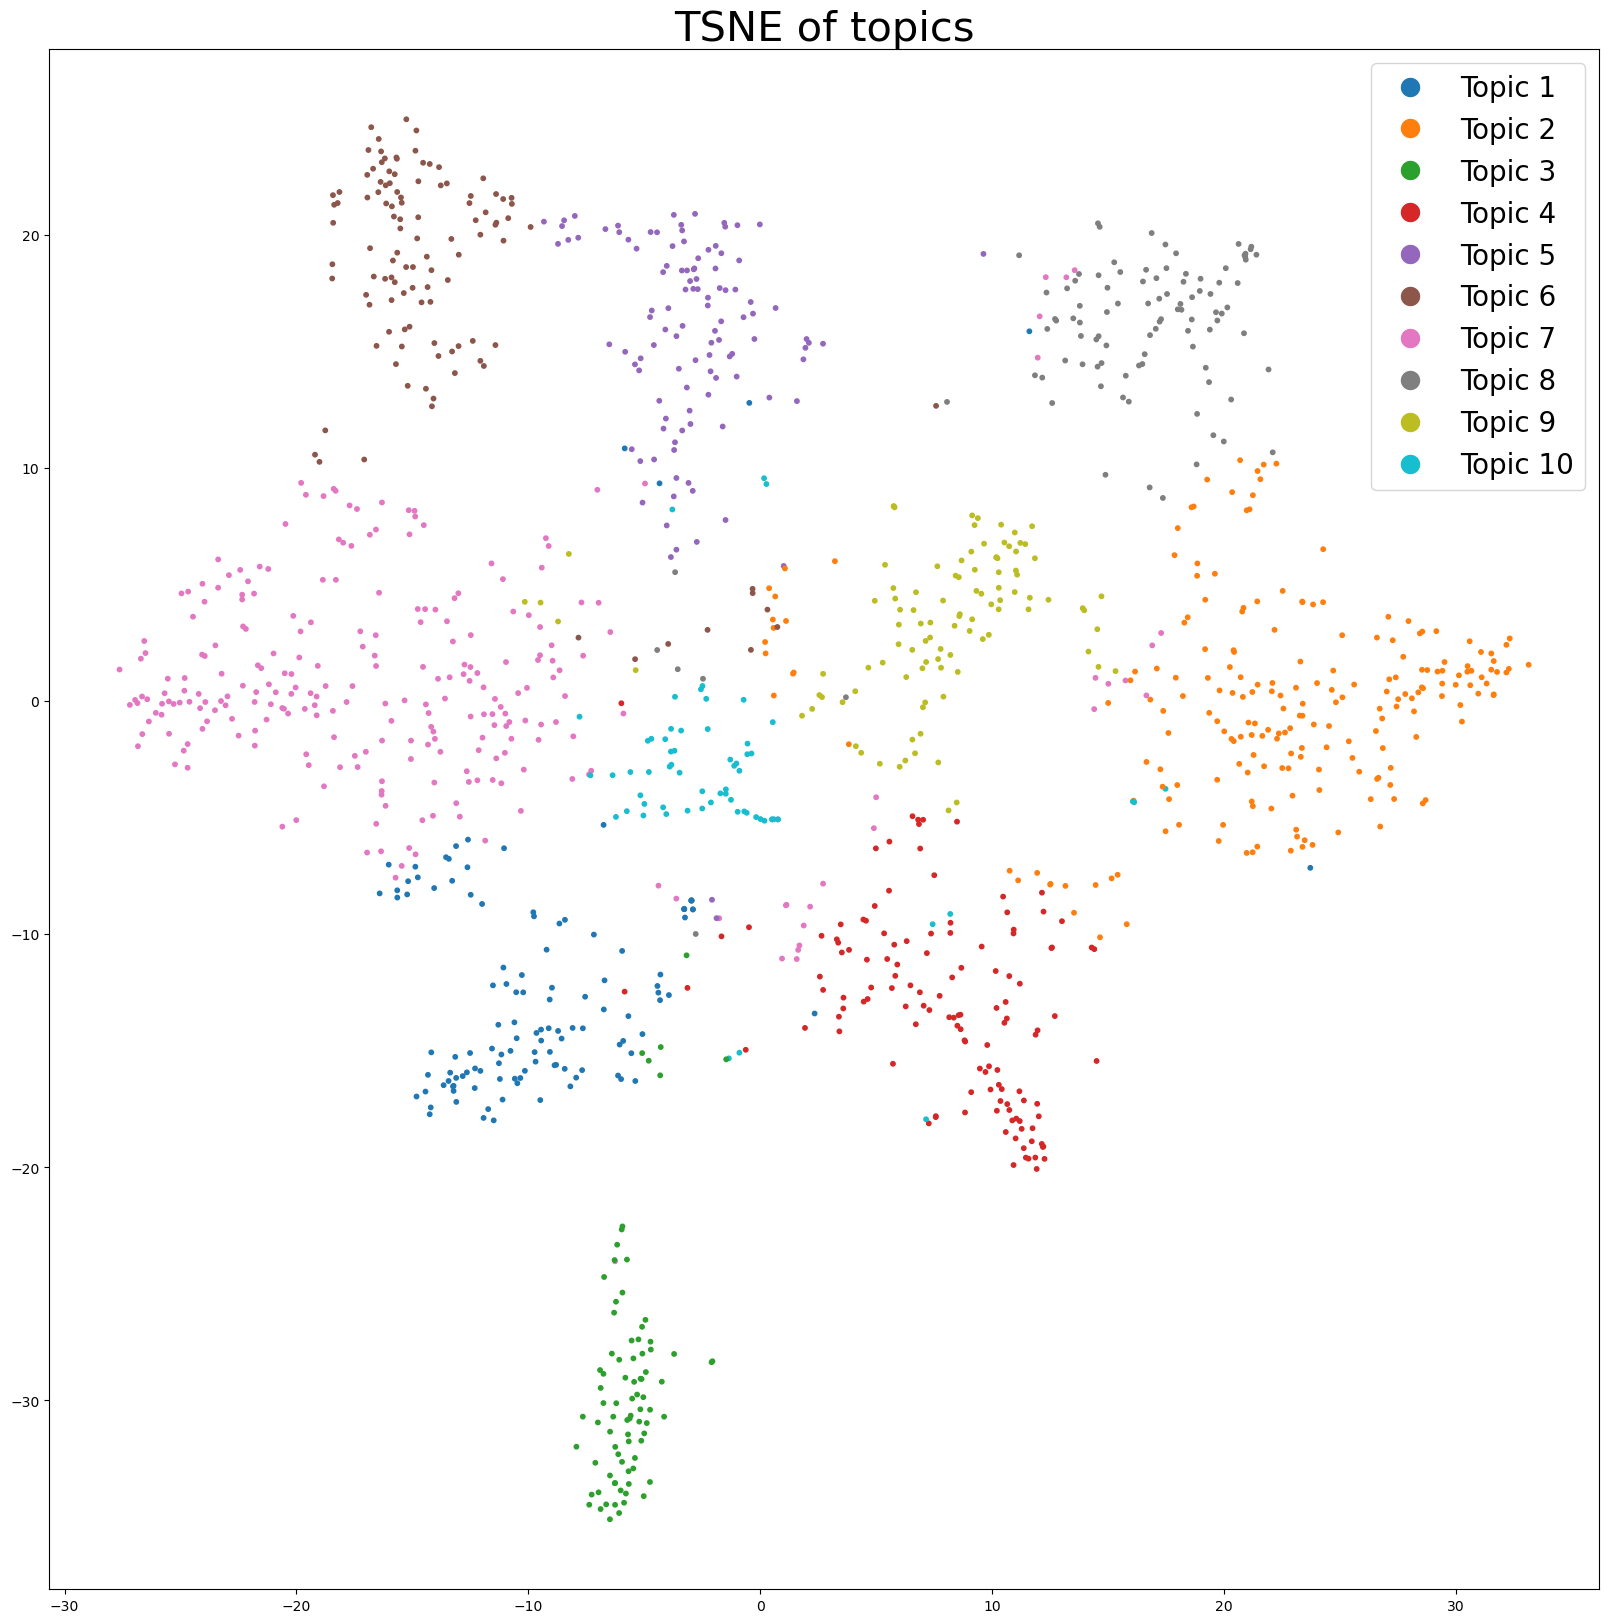

In [49]:
# TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=6452)
tsne_df = tsne.fit_transform(W_df)
# df with x,y header_id and topic
tsne_df = pd.DataFrame(tsne_df, columns=["x", "y"], index=W_df.index)
for i, row in nmf_df.iterrows():
    tsne_df.loc[row["header_id"], "topic"] = row["topic"]
    tsne_df.loc[row["header_id"], "topic_name"] = row["topic_name"]
    tsne_df.loc[row["header_id"], "header_eintrag"] = row["header_eintrag"]
    guess = C[C["header_id"] == row["header_id"]]["guess"].values[0]
    tsne_df.loc[row["header_id"], "guess"] = guess
# fix for zero-index
tsne_df["topic"] = tsne_df["topic"] + 1
# plot the tsne
plt.figure(figsize=(20,20))
plt.scatter(tsne_df["x"], tsne_df["y"], s=10, c=tsne_df["topic"], cmap="tab10")

# add a a legend
legend_elements = []
for i in range(n_topics):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f"Topic {i+1}", markerfacecolor=plt.cm.tab10(i), markersize=15))
plt.legend(handles=legend_elements, fontsize=20)
plt.title("TSNE of topics", fontsize=30)

plt.show()

In [51]:
import plotly.graph_objects as go

color_sequence = {1: "blue", 2: "orange", 3: "green", 4: "red", 5: "purple", 6: "brown", 7: "pink", 8: "grey", 9: "darkkhaki", 10: "cyan"}
topic_mapping = {1: "Courtly matters", 2: "Buildings", 3: "Culture", 4: "Culture / Theater?", 5: "Religion",
                6: "Suburbia", 7: "Entertainment?", 8: "Military? Bastions?", 9: "Suburbia", 10: "Paintigs (Art)"}

fig = go.Figure()

for topic_val, color in color_sequence.items():
    topic_df = tsne_df[tsne_df['topic'] == topic_val]
    fig.add_trace(go.Scatter(
        x=topic_df['x'],
        y=topic_df['y'],
        mode='markers',
        marker=dict(color=color),
        name = f"Topic {topic_val} - {topic_mapping[topic_val]}",
        text=topic_df["header_eintrag"] + "<br>" + "Topic:" + topic_df["topic_name"],
        hoverinfo="text"
    ))

fig.update_layout(
    title='TSNE of documents x topics',
    title_x=0.5,
    showlegend=True
)

fig.show()

fig.write_html("../output/tsne_plotly_doc_x_topix.html")

# Plot guess and topic

In [52]:
# assign number to guess categories
tsne_df["guess"] = tsne_df["guess"].astype("category")
tsne_df["guess_nr"] = tsne_df["guess"].cat.codes
guess_dict = dict(enumerate(tsne_df["guess"].cat.categories))

In [53]:
guess_dict[-1] = "no guess"

In [54]:
len(guess_dict)

5

C:\Users\N\AppData\Local\Temp\ipykernel_43732\1583532249.py:11: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



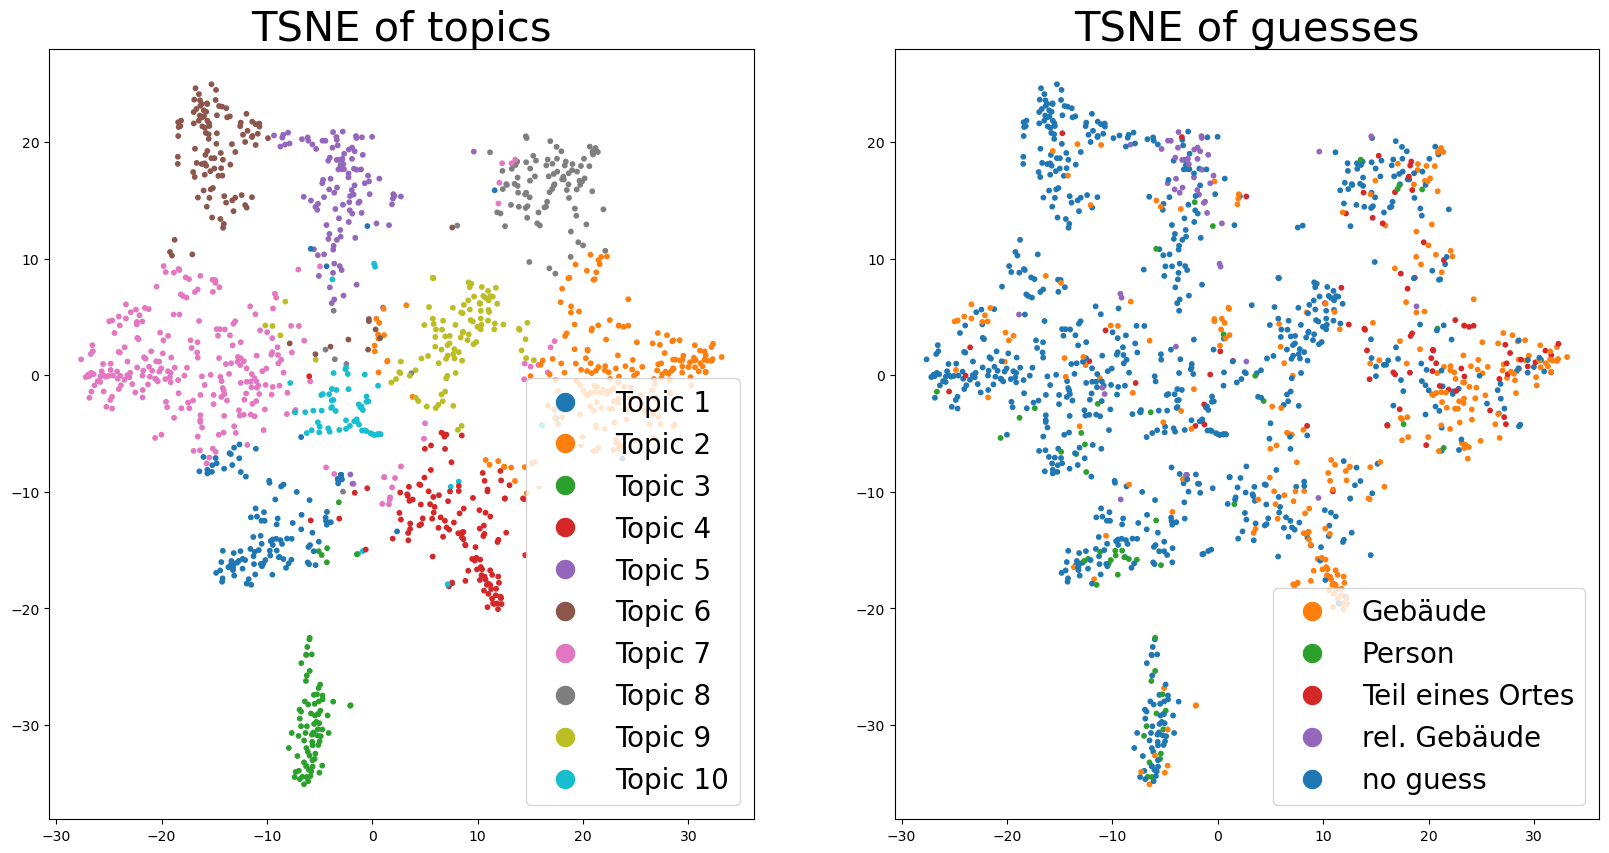

In [55]:
#plot colour by guess and topic side by side
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].scatter(tsne_df["x"], tsne_df["y"], s=10, c=tsne_df["topic"], cmap="tab10")
axes[0].set_title("TSNE of topics", fontsize=30)
legend_elements = []
for i in range(n_topics):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f"Topic {i+1}", markerfacecolor=plt.cm.tab10(i), markersize=15))
axes[0].legend(handles=legend_elements, fontsize=20)

axes[1].scatter(tsne_df["x"], tsne_df["y"], s=10, c=plt.cm.tab10(tsne_df["guess_nr"]+1), cmap="tab10")
axes[1].set_title("TSNE of guesses", fontsize=30)
legend_elements = []
for i in guess_dict.keys():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f"{guess_dict[i]}", markerfacecolor=plt.cm.tab10(i+1), markersize=15))
axes[1].legend(handles=legend_elements, fontsize=20)
plt.show()

# Plot TSNE and keywords

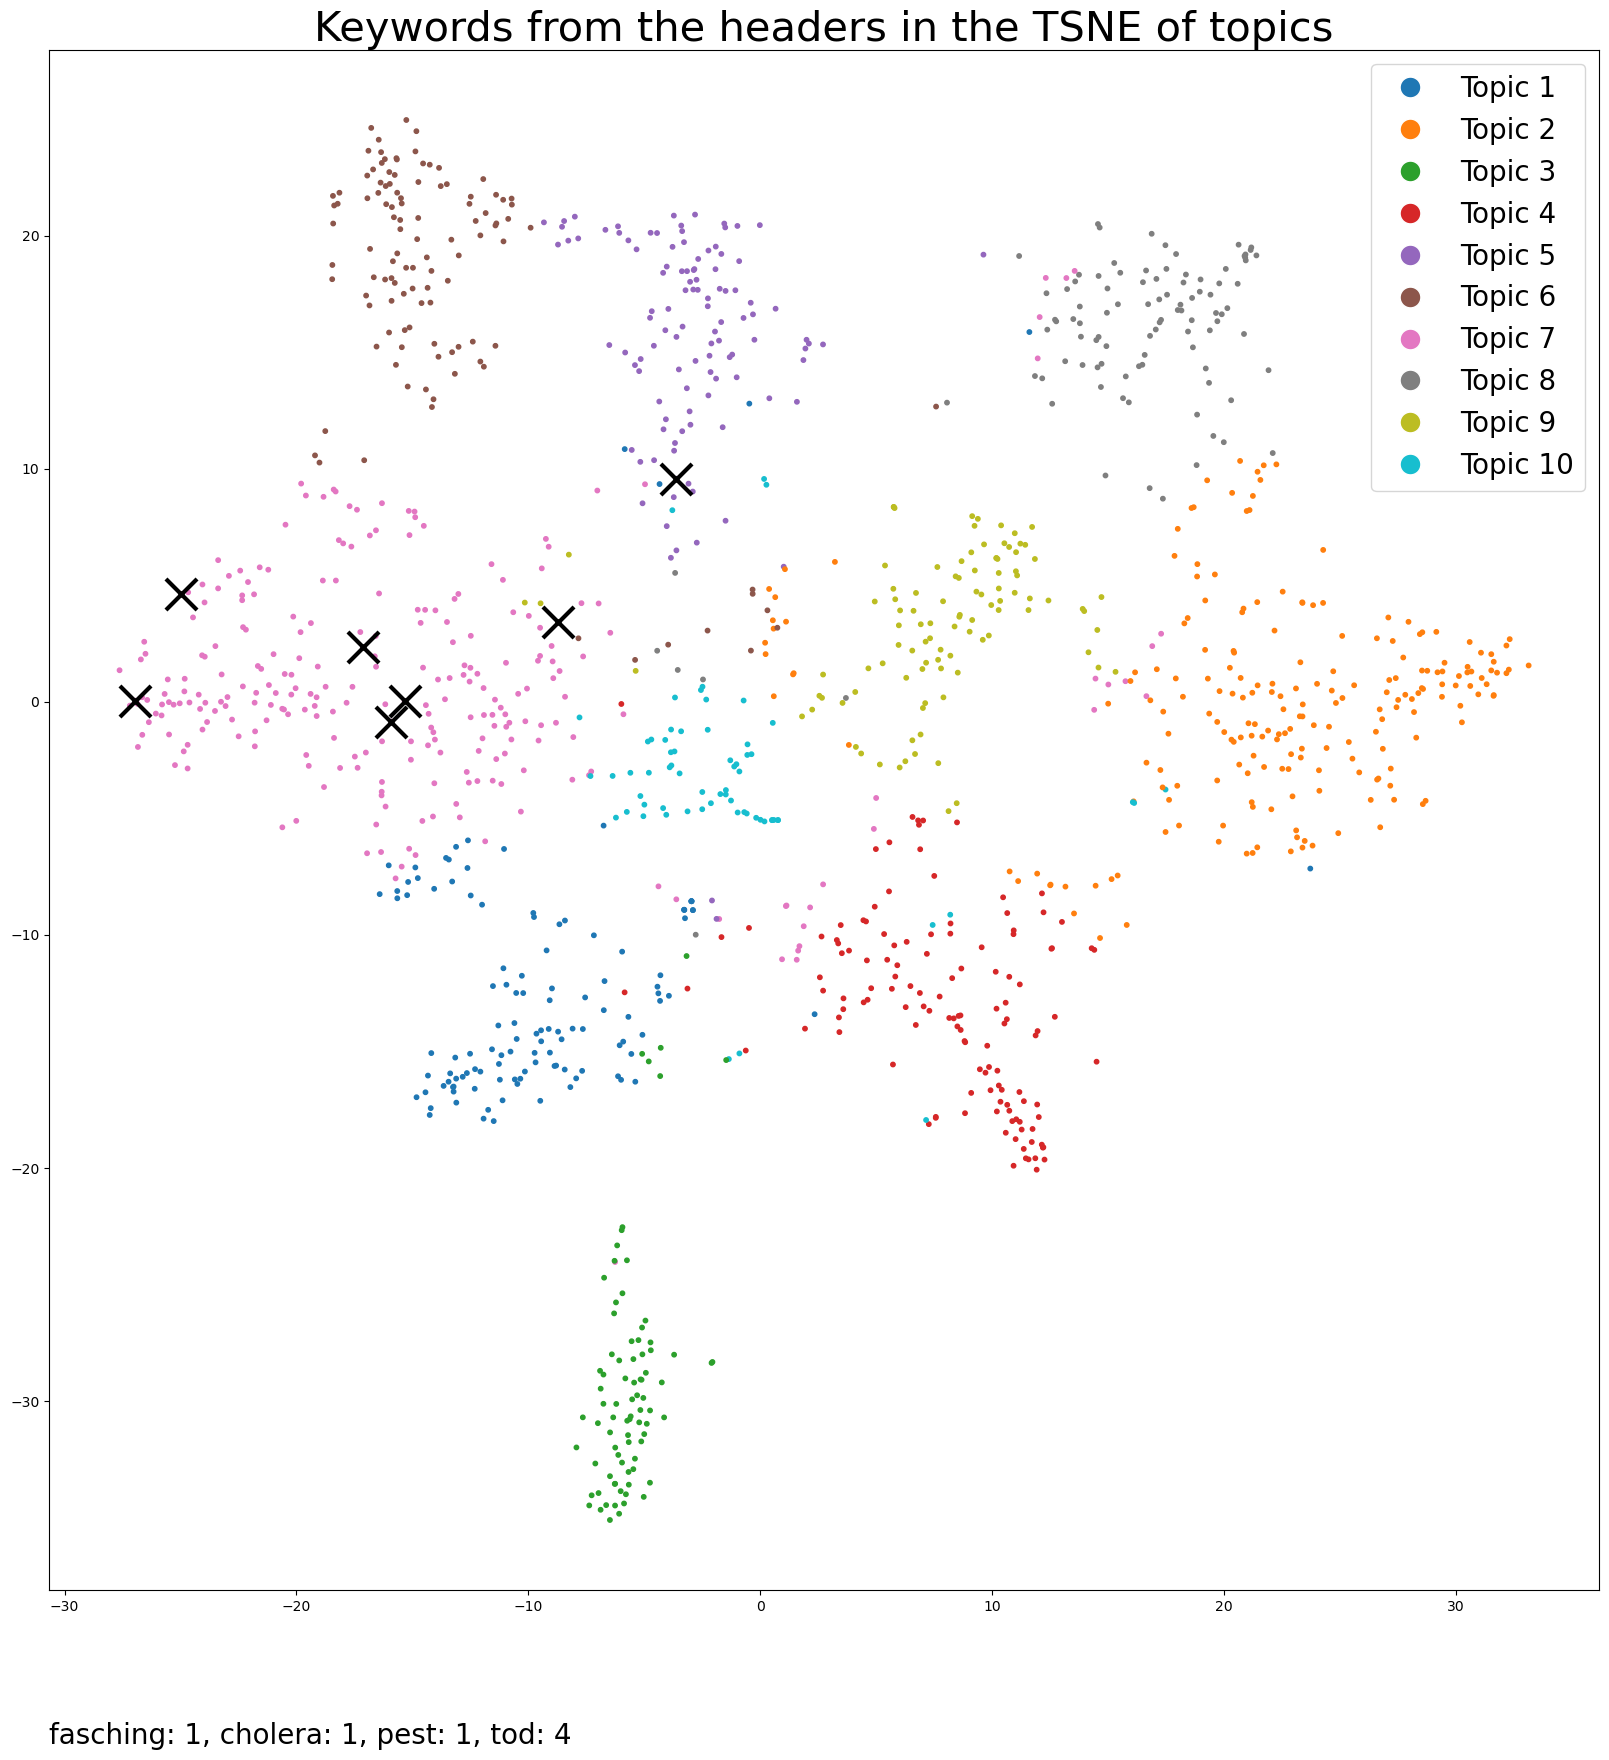

x         y  topic      topic_name  \
header_id                                                               
C1_facs_162_tr_1700430739 -15.904728 -0.844714    7.0  Entertainment?   
C1_facs_326_tr_1700432502  -8.717240  3.418508    9.0        Suburbia   
C1_facs_419_tr_1700430035 -26.958883  0.052105    7.0  Entertainment?   
C2_facs_199_tr_1700918722 -15.337132  0.032690    7.0  Entertainment?   
C2_facs_242_tr_1700921456 -17.140697  2.338840    7.0  Entertainment?   
C2_facs_374_tr_1700921583  -3.613780  9.574784    5.0        Religion   
C2_facs_374_tr_1700921585 -24.959539  4.622236    7.0  Entertainment?   

                                                              header_eintrag  \
header_id                                                                      
C1_facs_162_tr_1700430739  Beerdigung der Verbrecher\n(durch die Todten=B...   
C1_facs_326_tr_1700432502                                           Cholera.   
C1_facs_419_tr_1700430035                                  Faschingskrapfen.   
C2_facs_199_tr_1700918722                     Nächtliche Todtengesang (Der).   
C2_facs_242_tr_1700921456                                        Pest (Die).   
C2_facs_374_tr_1700921583                               Todten=Bruderschaft.   
C2_facs_374_tr_1700921585         Todtenkopf (Der). Haus und Bier=\nschenke.   

                             guess  guess_nr  
header_id                                     
C1_facs_162_tr_1700430739      NaN        -1  
C1_facs_326_tr_1700432502      NaN        -1  
C1_facs_419_tr_1700430035      NaN        -1  
C2_facs_199_tr_1700918722      NaN        -1  
C2_facs_242_tr_1700921456      NaN        -1  
C2_facs_374_tr_1700921583      NaN        -1  
C2_facs_374_tr_1700921585  Gebäude         0

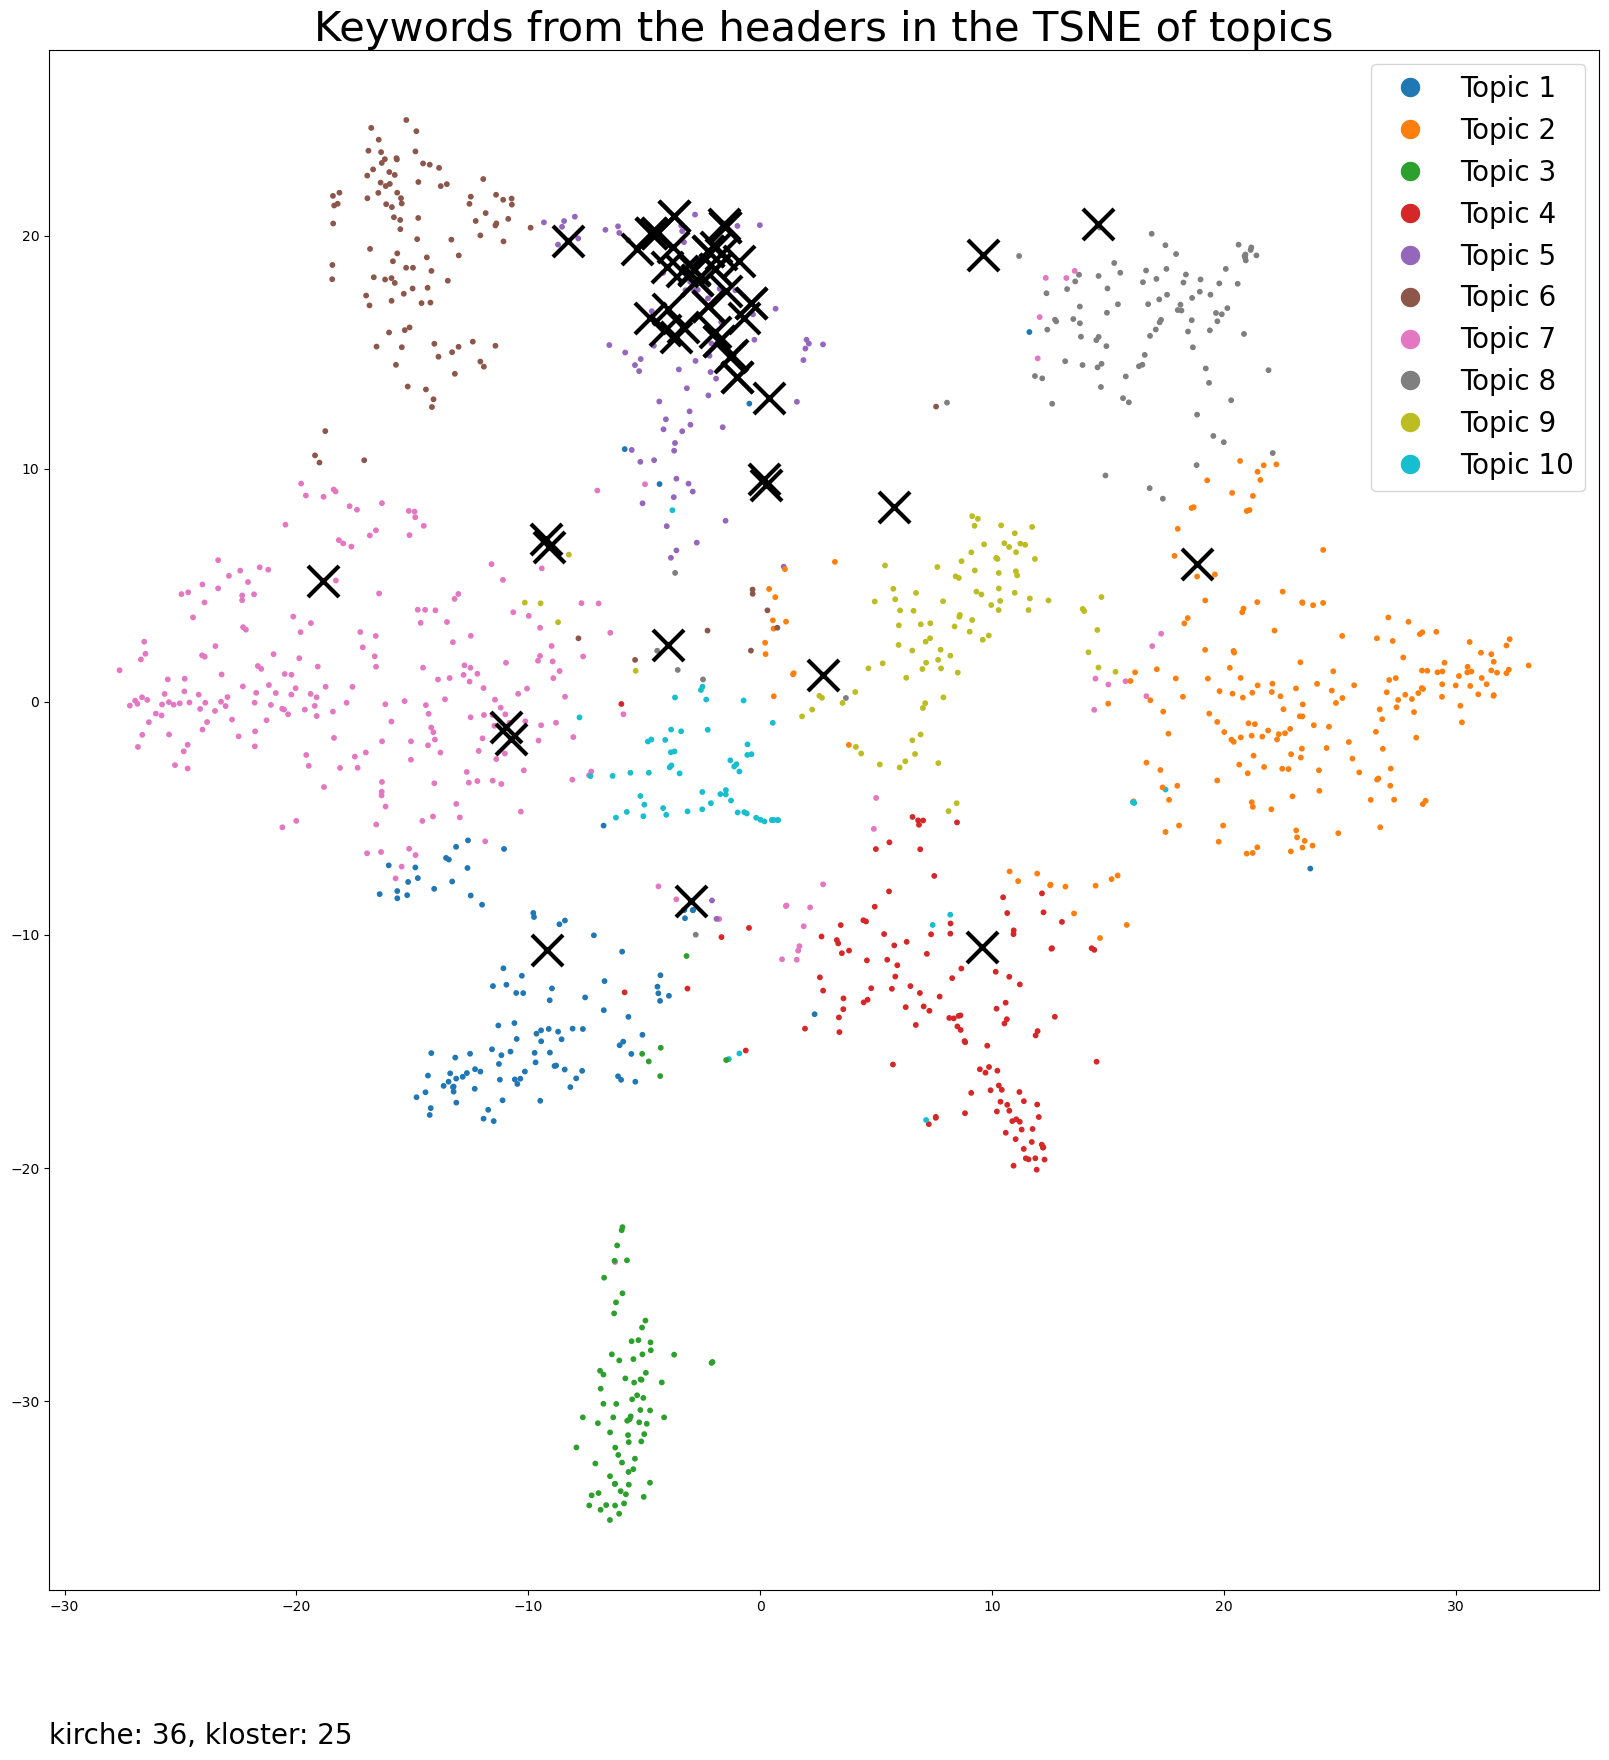

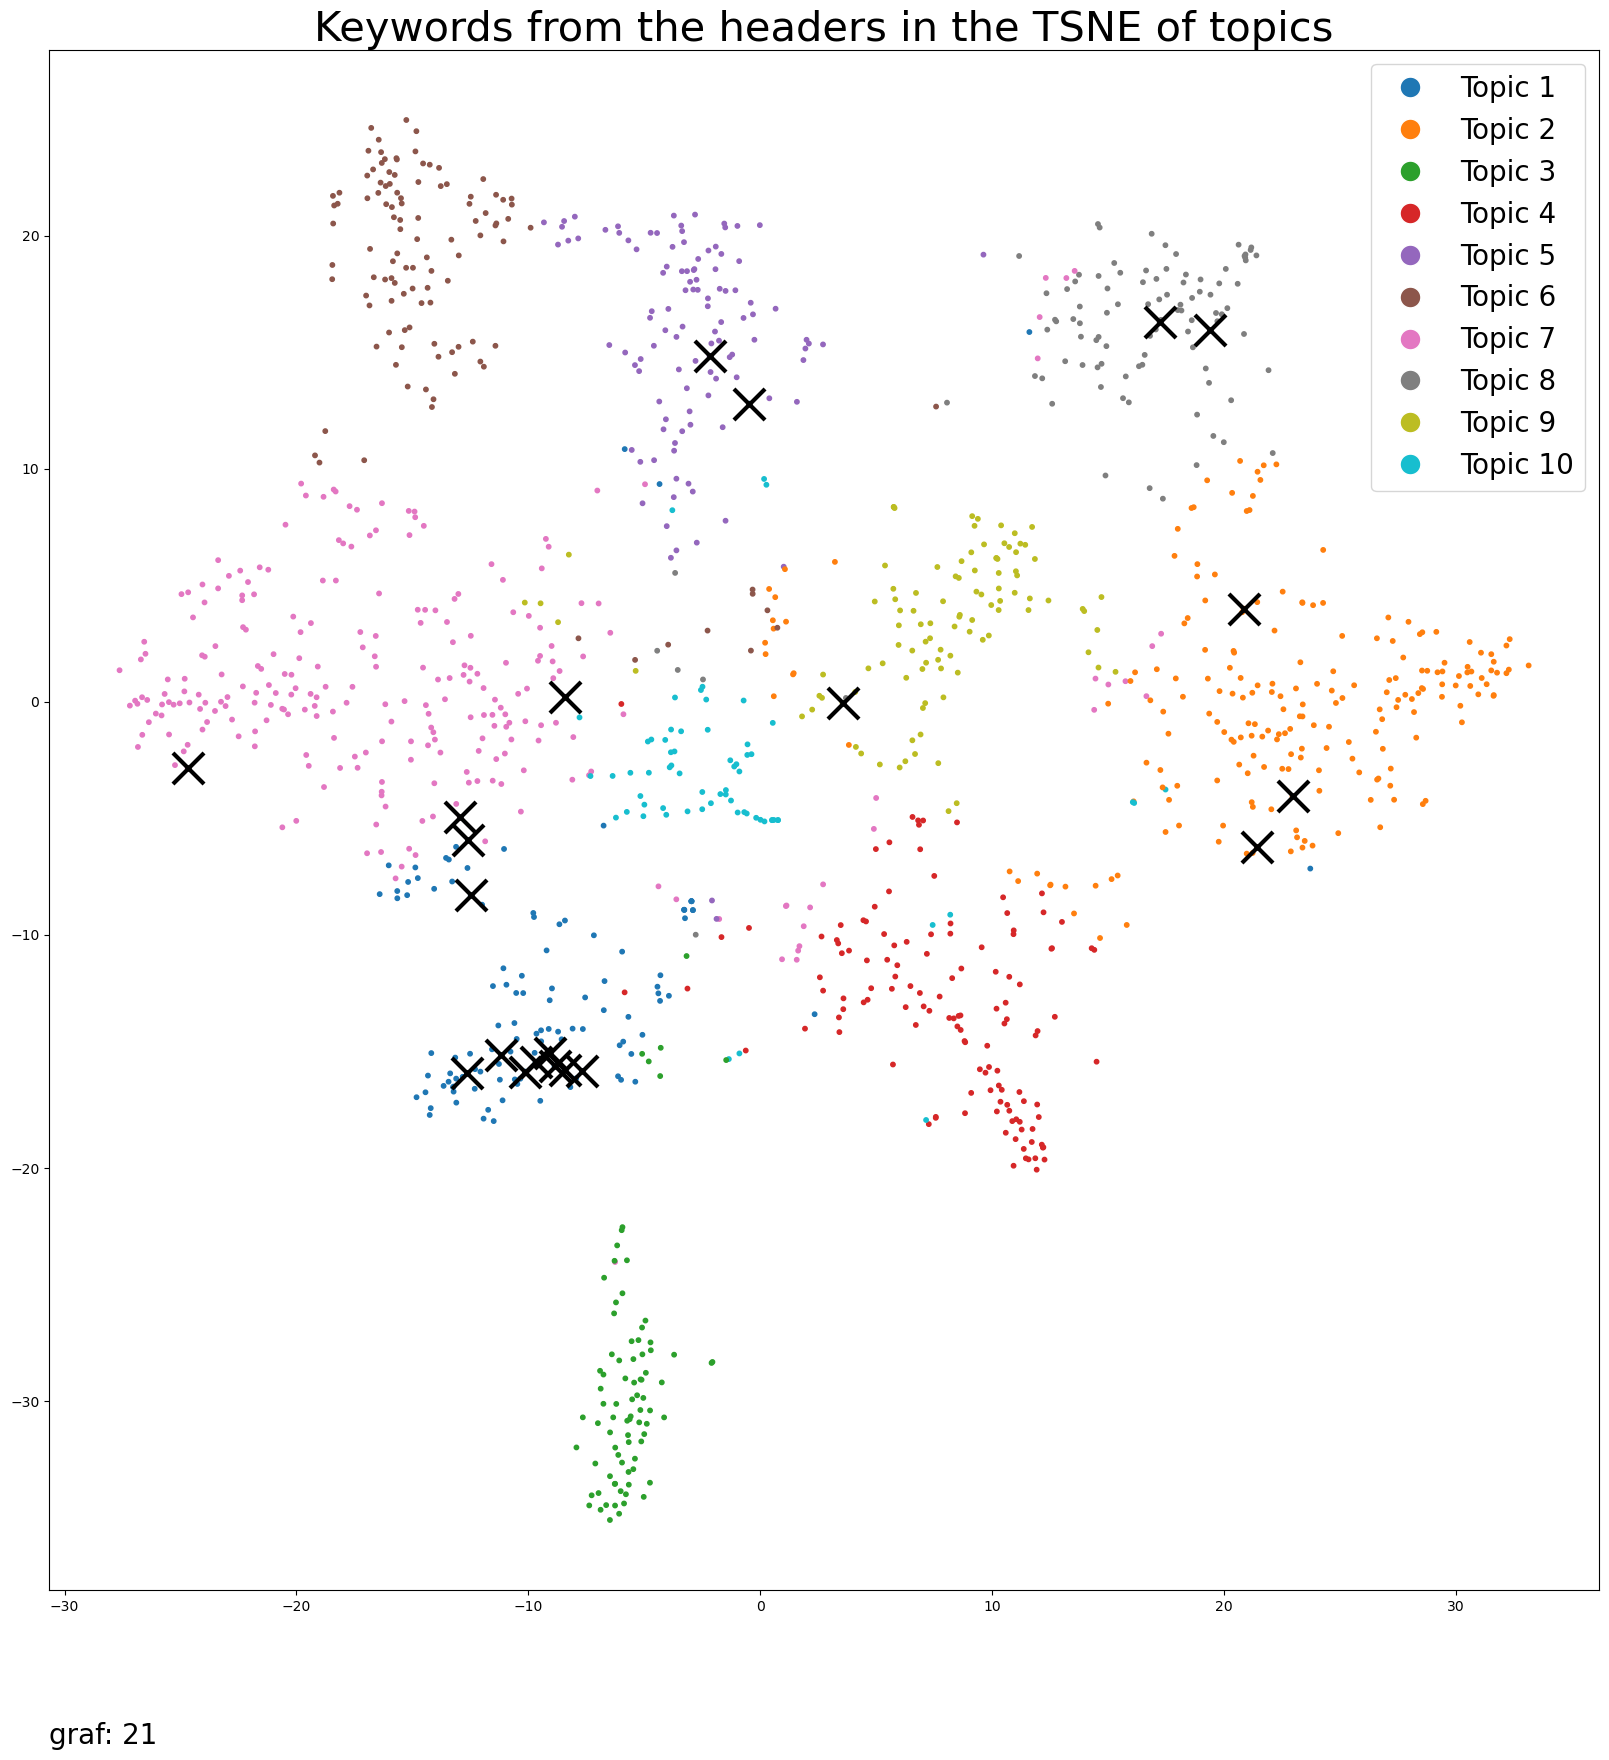

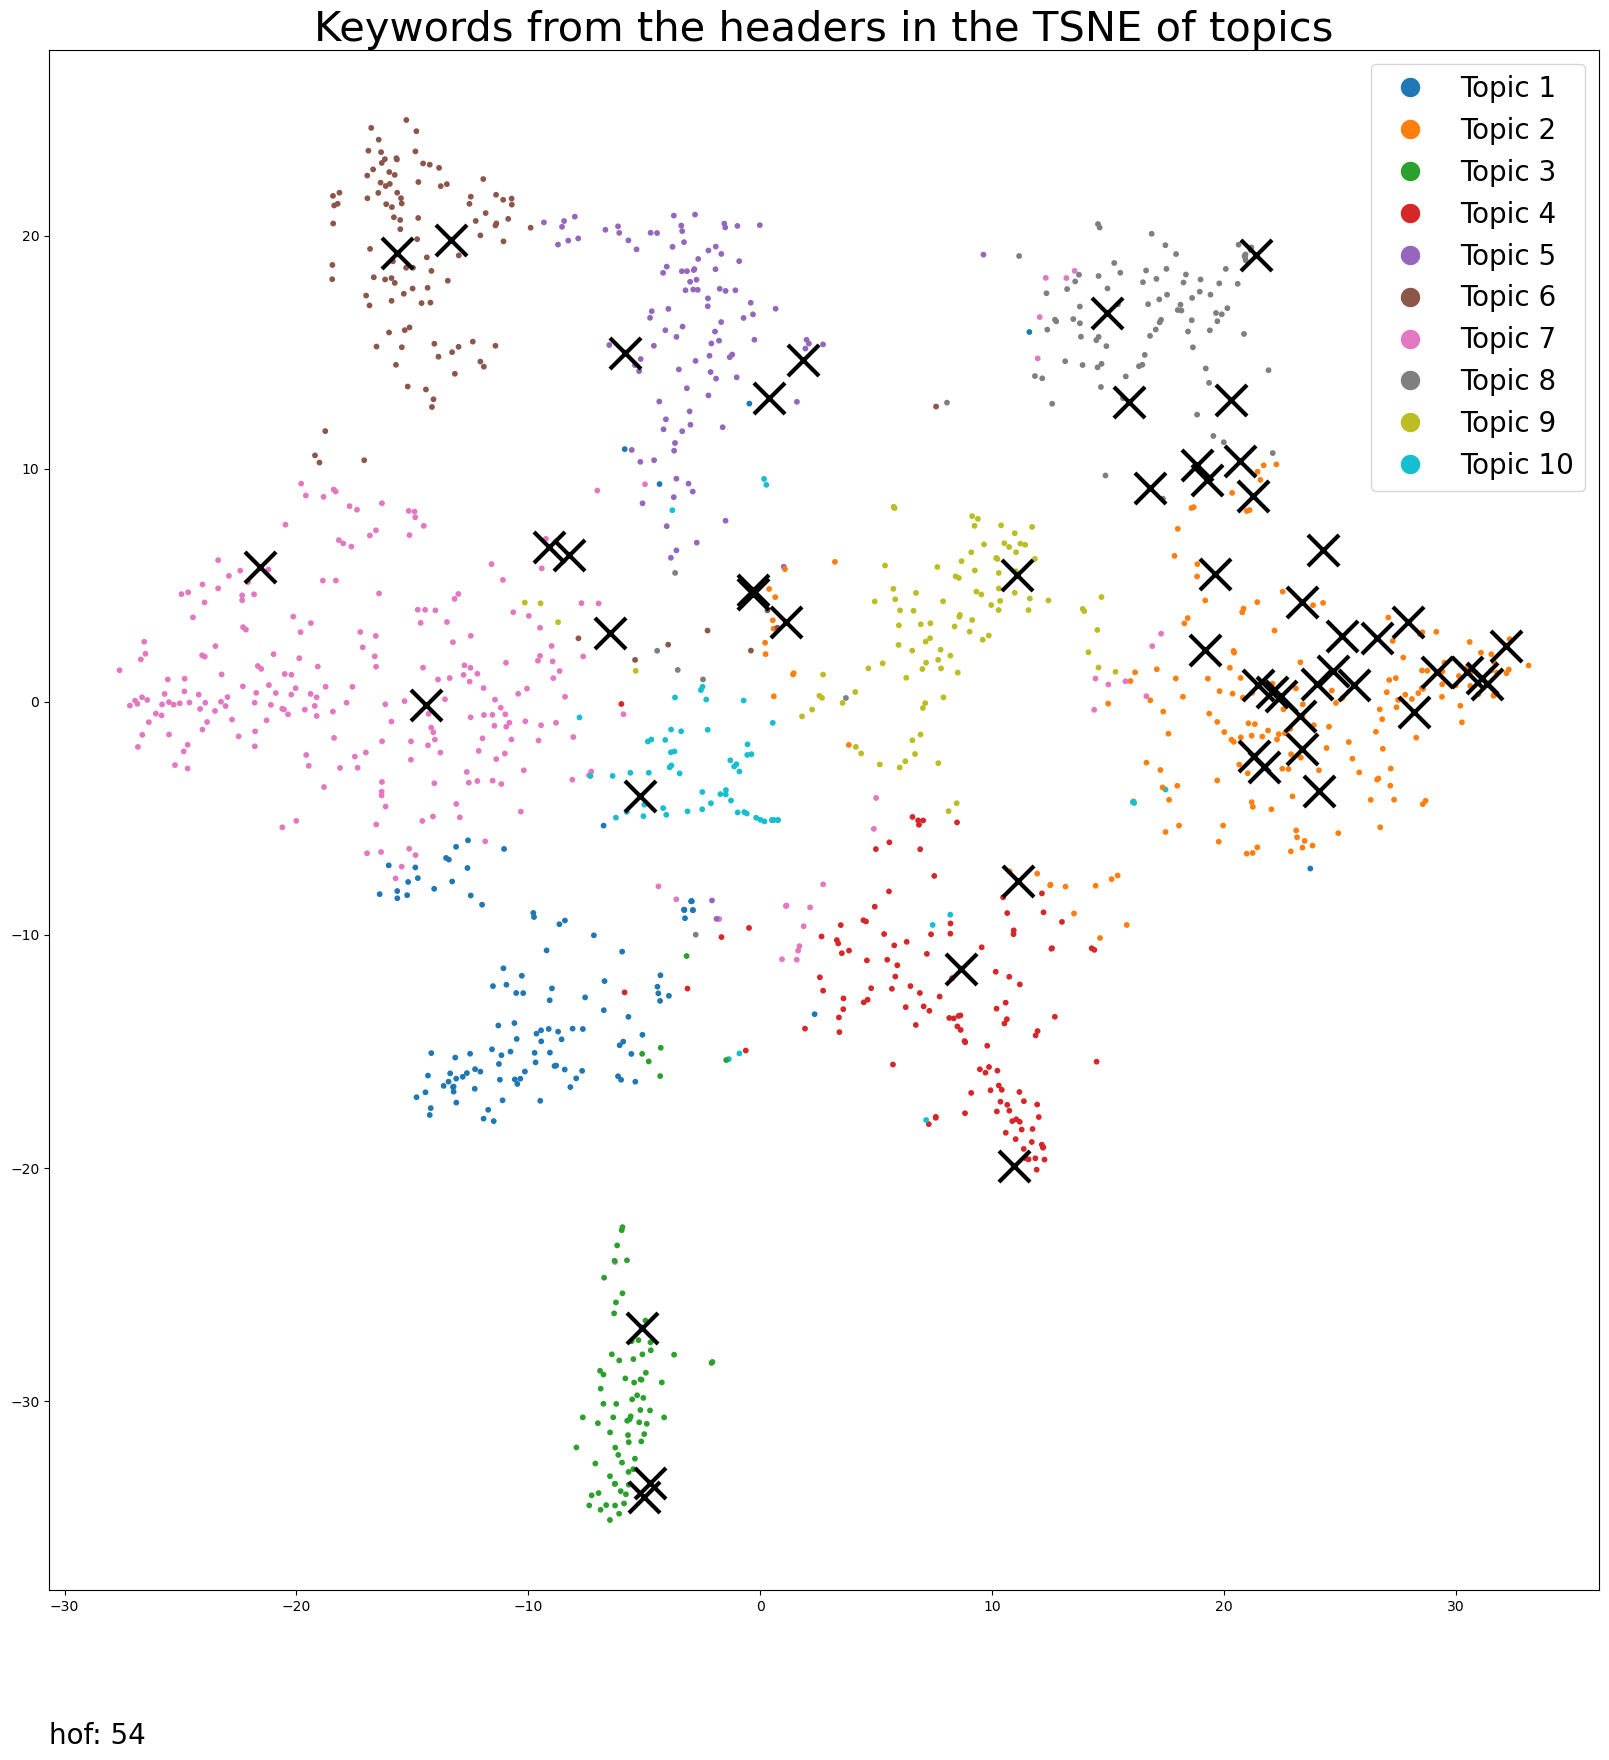

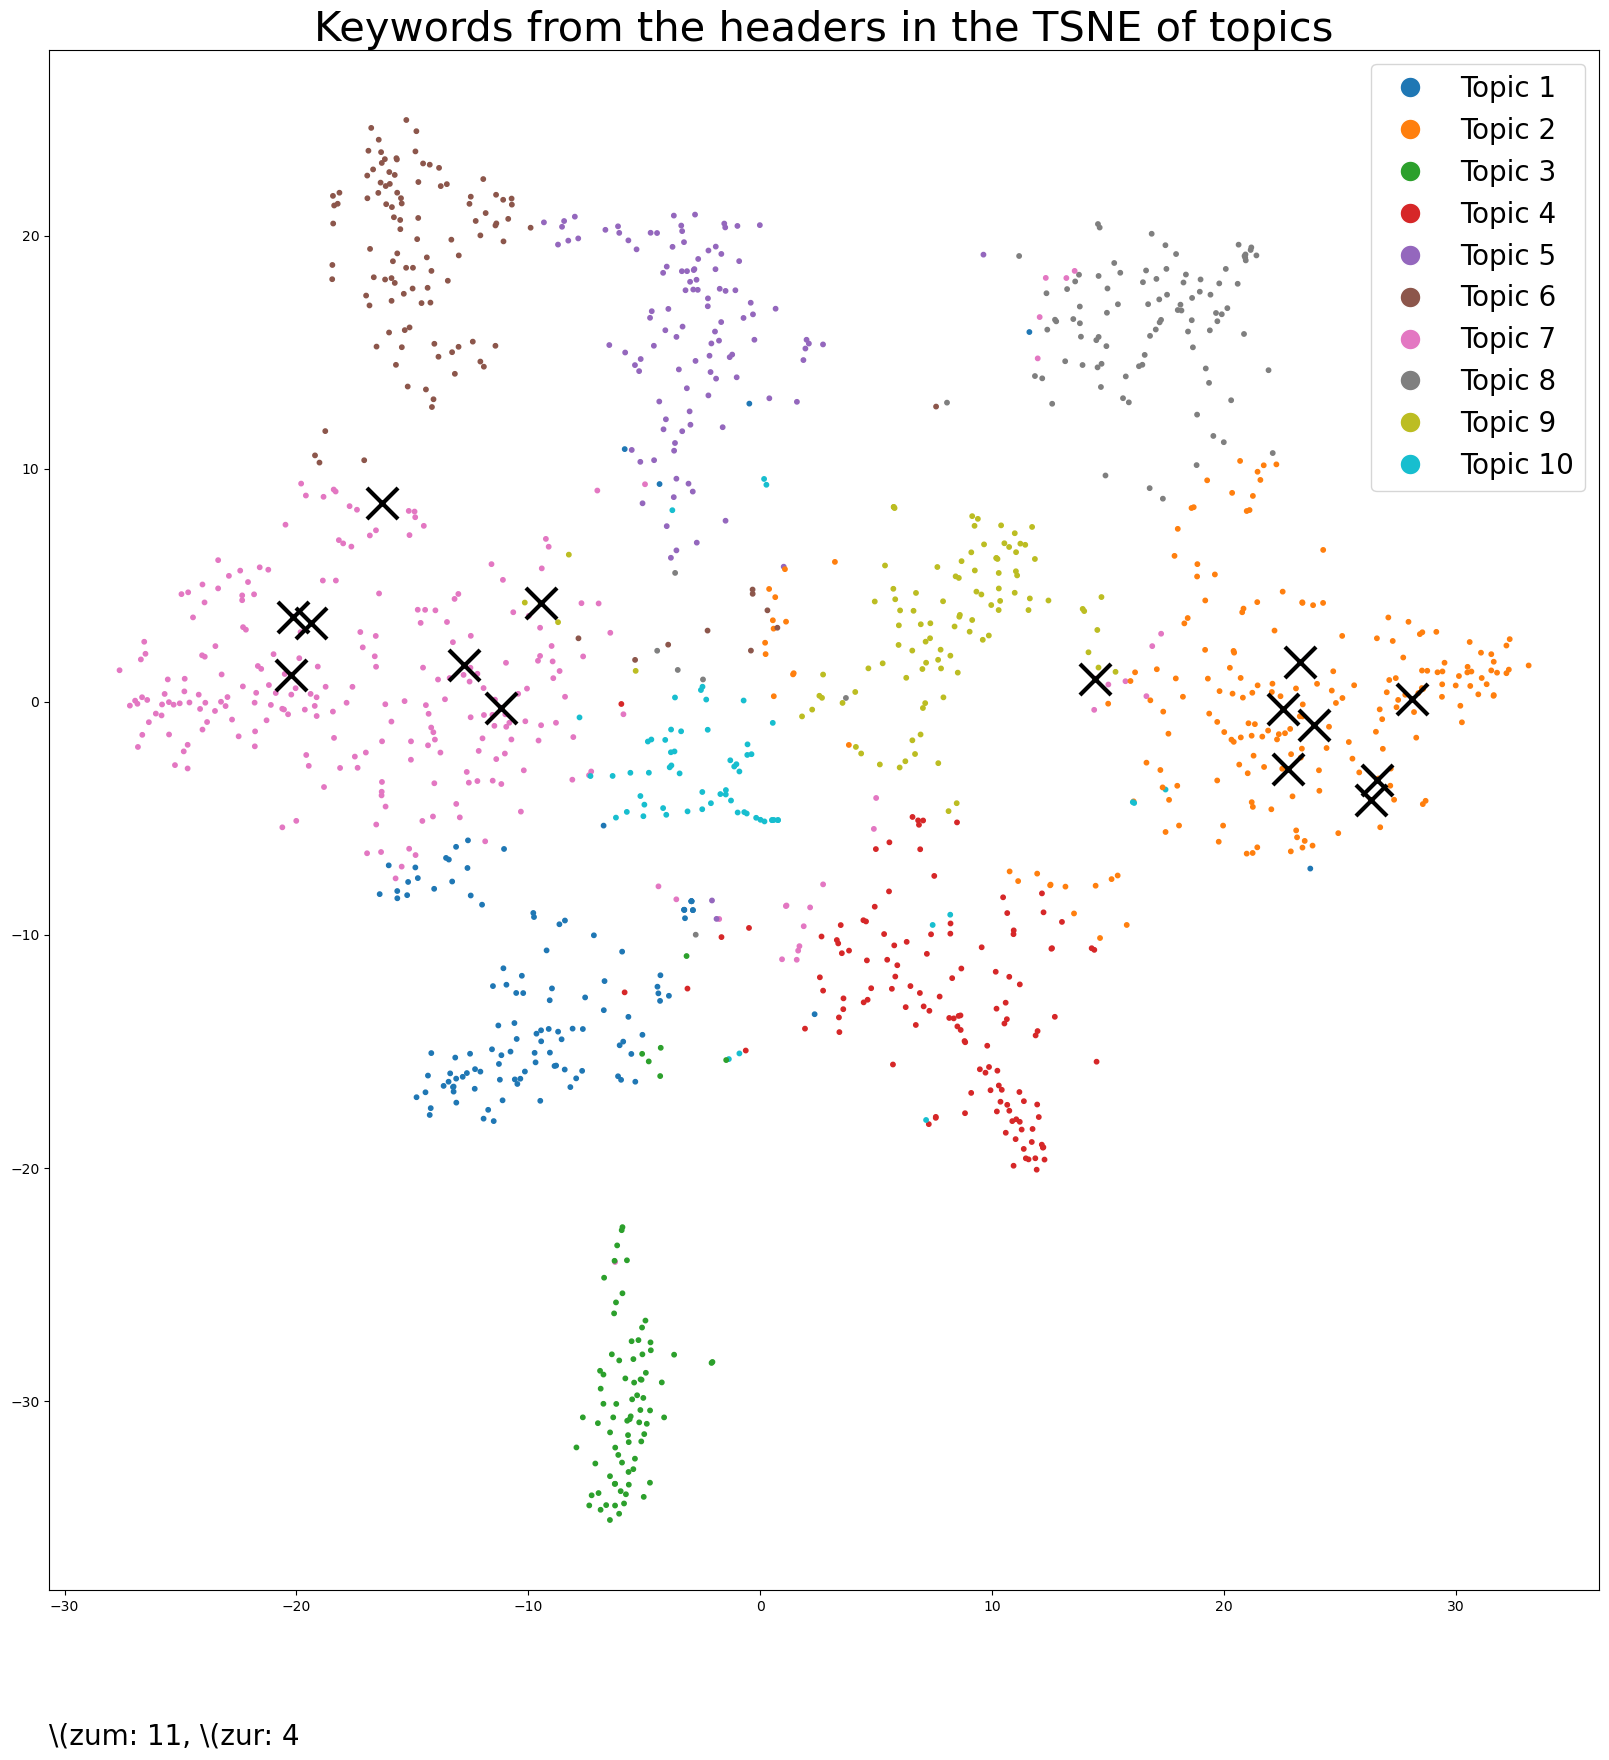

x         y  topic  \
header_id                                                         
C1_facs_12_region_1699103256772_233 -11.188526 -0.248519    7.0   
C1_facs_215_tr_1700430960           -19.377220  3.380318    7.0   
C1_facs_244_tr_1700432515            -9.471540  4.228165    9.0   
C1_facs_327_tr_1700431264            22.567026 -0.316618    2.0   
C1_facs_356_tr_1700322707            23.878050 -1.000324    2.0   
C1_facs_393_tr_1700430675            23.298115  1.698187    2.0   
C1_facs_460_tr_1700432166            14.461271  0.999251    7.0   
C1_facs_498_tr_1700430521            26.607613 -3.335106    2.0   
C1_facs_499_tr_1700430436           -16.312456  8.523307    7.0   
C1_facs_518_tr_1700432362           -20.138481  3.658077    7.0   
C2_facs_50_tr_1700920557            -20.216812  1.164250    7.0   
C2_facs_162_tr_1700921732            26.333652 -4.203789    2.0   
C2_facs_288_tr_1700921354            28.108349  0.122245    2.0   
C2_facs_303_tr_1700920596           -12.753672  1.567859    7.0   
C2_facs_343_tr_1700920175            22.785774 -2.882261    2.0   

                                         topic_name           header_eintrag  \
header_id                                                                      
C1_facs_12_region_1699103256772_233  Entertainment?      Adam und Eva (Zum).   
C1_facs_215_tr_1700430960            Entertainment?     Birne (Zur eisernen)   
C1_facs_244_tr_1700432515                  Suburbia     Bretze (Zur rothen).   
C1_facs_327_tr_1700431264                 Buildings   Christoph (Zum großen)   
C1_facs_356_tr_1700322707                 Buildings              Dachl (Zum)   
C1_facs_393_tr_1700430675                 Buildings  Einhorn (Zum goldenen).   
C1_facs_460_tr_1700432166            Entertainment?  Fuchs (Zum geprellten).   
C1_facs_498_tr_1700430521                 Buildings          Godl (Zur Frau)   
C1_facs_499_tr_1700430436            Entertainment?     Goldenen Birne (Zur)   
C1_facs_518_tr_1700432362            Entertainment?      Hader (Zum nassen).   
C2_facs_50_tr_1700920557             Entertainment?  Hund (Zum gepanzerten).   
C2_facs_162_tr_1700921732                 Buildings      Mandel (Zum rothen)   
C2_facs_288_tr_1700921354                 Buildings       Rößel (Zum weißen)   
C2_facs_303_tr_1700920596            Entertainment?             Schekl (Zum)   
C2_facs_343_tr_1700920175                 Buildings             Sperl (Zum).   

                                       guess  guess_nr  
header_id                                               
C1_facs_12_region_1699103256772_233  Gebäude         0  
C1_facs_215_tr_1700430960            Gebäude         0  
C1_facs_244_tr_1700432515            Gebäude         0  
C1_facs_327_tr_1700431264            Gebäude         0  
C1_facs_356_tr_1700322707            Gebäude         0  
C1_facs_393_tr_1700430675            Gebäude         0  
C1_facs_460_tr_1700432166            Gebäude         0  
C1_facs_498_tr_1700430521            Gebäude         0  
C1_facs_499_tr_1700430436            Gebäude         0  
C1_facs_518_tr_1700432362            Gebäude         0  
C2_facs_50_tr_1700920557             Gebäude         0  
C2_facs_162_tr_1700921732            Gebäude         0  
C2_facs_288_tr_1700921354            Gebäude         0  
C2_facs_303_tr_1700920596            Gebäude         0  
C2_facs_343_tr_1700920175            Gebäude         0

In [56]:
def plot_tsne_for_keywords(keywords, tsne_df, display_df=False):
    """Plot the tsne with the keywords highlighted"""
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(tsne_df["x"], tsne_df["y"], s=10, c=tsne_df["topic"], cmap="tab10")
    ax.set_title("Keywords from the headers in the TSNE of topics", fontsize=30)
    legend_elements = []
    for i in range(n_topics):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f"Topic {i+1}", markerfacecolor=plt.cm.tab10(i), markersize=15))
    ax.legend(handles=legend_elements, fontsize=20)
    # add the keywords
    info = []
    for keyword in keywords:
        temp_df = tsne_df[tsne_df["header_eintrag"].str.lower().str.contains(keyword)]
        ax.scatter(temp_df["x"], temp_df["y"], marker="x", label=keyword, s = 500, linewidth=3, c = "black")
        info.append(f"{keyword}: {len(temp_df)}")
    # add text at the bottom
    info_txt = ", ".join(info)
    ax.text(0, -0.1, info_txt, transform=ax.transAxes, fontsize=20)
    plt.show()
    if display_df:
        display(tsne_df[tsne_df["header_eintrag"].str.lower().str.contains("|".join(x for x in keywords))])
    

plot_tsne_for_keywords("fasching, cholera, pest, tod".split(", "), tsne_df, True)
plot_tsne_for_keywords(["kirche", "kloster"], tsne_df)
plot_tsne_for_keywords(["graf"], tsne_df)
plot_tsne_for_keywords(["hof"], tsne_df)
plot_tsne_for_keywords(["\(zum", "\(zur"], tsne_df, True)

In [57]:

def plot_tsne_for_keywords_in_plotly(keywords, tsne_df):
    """Plot the tsne with the keywords highlighted"""
    fig = px.scatter(tsne_df, x="x", y="y", color="topic", hover_data=["topic", "header_eintrag"])
    fig.update_layout(title="Keywords from the headers in the TSNE of topics", title_font_size=30)
    
    # add the keywords
    info = []
    for keyword in keywords:
        temp_df = tsne_df[tsne_df["header_eintrag"].str.lower().str.contains(keyword)]
        if not temp_df.empty:
            # the x should be over the dots
            fig.add_scatter(
                x=temp_df["x"], y=temp_df["y"], mode='markers',
                marker=dict(symbol="x", size=10, color="black"),
                name=keyword,
                hovertext=temp_df["header_eintrag"] + " (topic " + temp_df["topic"].astype(str) + ")",
            )
            info.append(f"{keyword}: {len(temp_df)}")
    
    # change the order: first x, then dots
    fig.data = fig.data[::-1]


    info_txt = ", ".join(info)
    # no colour bar
    fig.update_layout(showlegend=True)
    fig.update_layout(coloraxis_showscale=False)
    fig.show()

plot_tsne_for_keywords_in_plotly(["kirche", "kloster"], tsne_df)

In [29]:
import plotly.graph_objects as go

def plot_tsne_for_keywords_in_plotly(keywords, tsne_df ):
    """Plot the tsne with the keywords highlighted in plotly"""
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=tsne_df["x"], y=tsne_df["y"], mode="markers", marker=dict(size=5, color=tsne_df["topic"], colorscale="agsunset")))
    
    fig.update_layout(title="Keywords from the headers in the TSNE of topics", title_font_size=20)
    # add the keywords
    info = []
    for keyword in keywords:
        temp_df = tsne_df[tsne_df["header_eintrag"].str.lower().str.contains(keyword)]
        fig.add_trace(go.Scatter(x=temp_df["x"], y=temp_df["y"], mode="markers", marker=dict(size=10, color="black", symbol="x")))
        info.append(f"{keyword}: {len(temp_df)}")
    # add text at the bottom
    info_txt = ", ".join(info)
    fig.add_annotation(text=info_txt, xref="paper", yref="paper", x=0, y=-0.1, showarrow=False, font=dict(size=20))
    fig.show()

plot_tsne_for_keywords_in_plotly(["kirche", "kloster"], tsne_df)

# TSNE of topic-term matrix

In [58]:
H_df

abbildung  abbildung zeigt  abbildungen  abbrechen   abbruch  abbruche  \
0   0.000000         0.001716     0.000000   0.000000  0.001873  0.000000   
1   0.010624         0.000000     0.012217   0.002843  0.019650  0.022287   
2   0.005852         0.009010     0.001390   0.000000  0.007846  0.000000   
3   0.000892         0.000000     0.014094   0.000000  0.001161  0.000000   
4   0.034987         0.000000     0.016362   0.010716  0.000000  0.000000   
5   0.001582         0.000695     0.000000   0.001119  0.000000  0.000000   
6   0.034834         0.007503     0.000000   0.004988  0.000000  0.000000   
7   0.005957         0.001387     0.000890   0.004264  0.000000  0.000613   
8   0.000000         0.000000     0.000000   0.000000  0.000000  0.000000   
9   0.029710         0.000000     0.012521   0.003292  0.022220  0.004636   

       abel     abend    abende    abends  ...  überstandenen  übertraf  \
0  0.000000  0.009304  0.000000  0.003352  ...       0.003102  0.004252   
1  0.000000  0.000000  0.000000  0.000000  ...       0.000608  0.000000   
2  0.000000  0.000000  0.004190  0.000000  ...       0.000000  0.014225   
3  0.000141  0.000000  0.000000  0.000000  ...       0.004348  0.002916   
4  0.001666  0.000000  0.000000  0.008996  ...       0.000000  0.000000   
5  0.000000  0.012390  0.000020  0.000000  ...       0.000000  0.000000   
6  0.000000  0.024551  0.012176  0.038816  ...       0.015381  0.003308   
7  0.004767  0.004227  0.008338  0.026839  ...       0.000000  0.000844   
8  0.000000  0.000000  0.000000  0.028507  ...       0.000000  0.000000   
9  0.036961  0.000000  0.011266  0.007414  ...       0.000000  0.000000   

   übertragen  übertreffen  übertrifft  übertrug  überzeugt    üblich  \
0    0.036590     0.000000    0.000000  0.026934   0.006112  0.008623   
1    0.000000     0.000000    0.003738  0.000000   0.000000  0.000000   
2    0.012443     0.015361    0.000000  0.016710   0.005792  0.001773   
3    0.021907     0.000097    0.000000  0.000000   0.000000  0.000000   
4    0.053859     0.000000    0.000000  0.010445   0.000000  0.000000   
5    0.000000     0.006633    0.011257  0.008348   0.000000  0.000000   
6    0.000000     0.006374    0.003053  0.000000   0.014881  0.020310   
7    0.000000     0.000000    0.000000  0.000000   0.000000  0.000000   
8    0.017387     0.002219    0.000000  0.000000   0.000831  0.005868   
9    0.002213     0.000000    0.000000  0.000000   0.000000  0.000000   

     übrige   übrigen  
0  0.000000  0.015380  
1  0.000000  0.002968  
2  0.000000  0.000000  
3  0.003334  0.030960  
4  0.001804  0.041048  
5  0.017087  0.008869  
6  0.000753  0.039858  
7  0.006419  0.020346  
8  0.011617  0.025175  
9  0.000000  0.008188  

[10 rows x 8126 columns]

In [59]:
tsne = TSNE(n_components=2, perplexity=50, random_state=6452)

tsne_df = tsne.fit_transform(H_df.T)
# df with x,y header_id and topic
tsne_df = pd.DataFrame(tsne_df, columns=["x", "y"], index=H_df.T.index)
# max associated topic for term
tsne_df["topic"] = H_df.T.idxmax(axis=1)

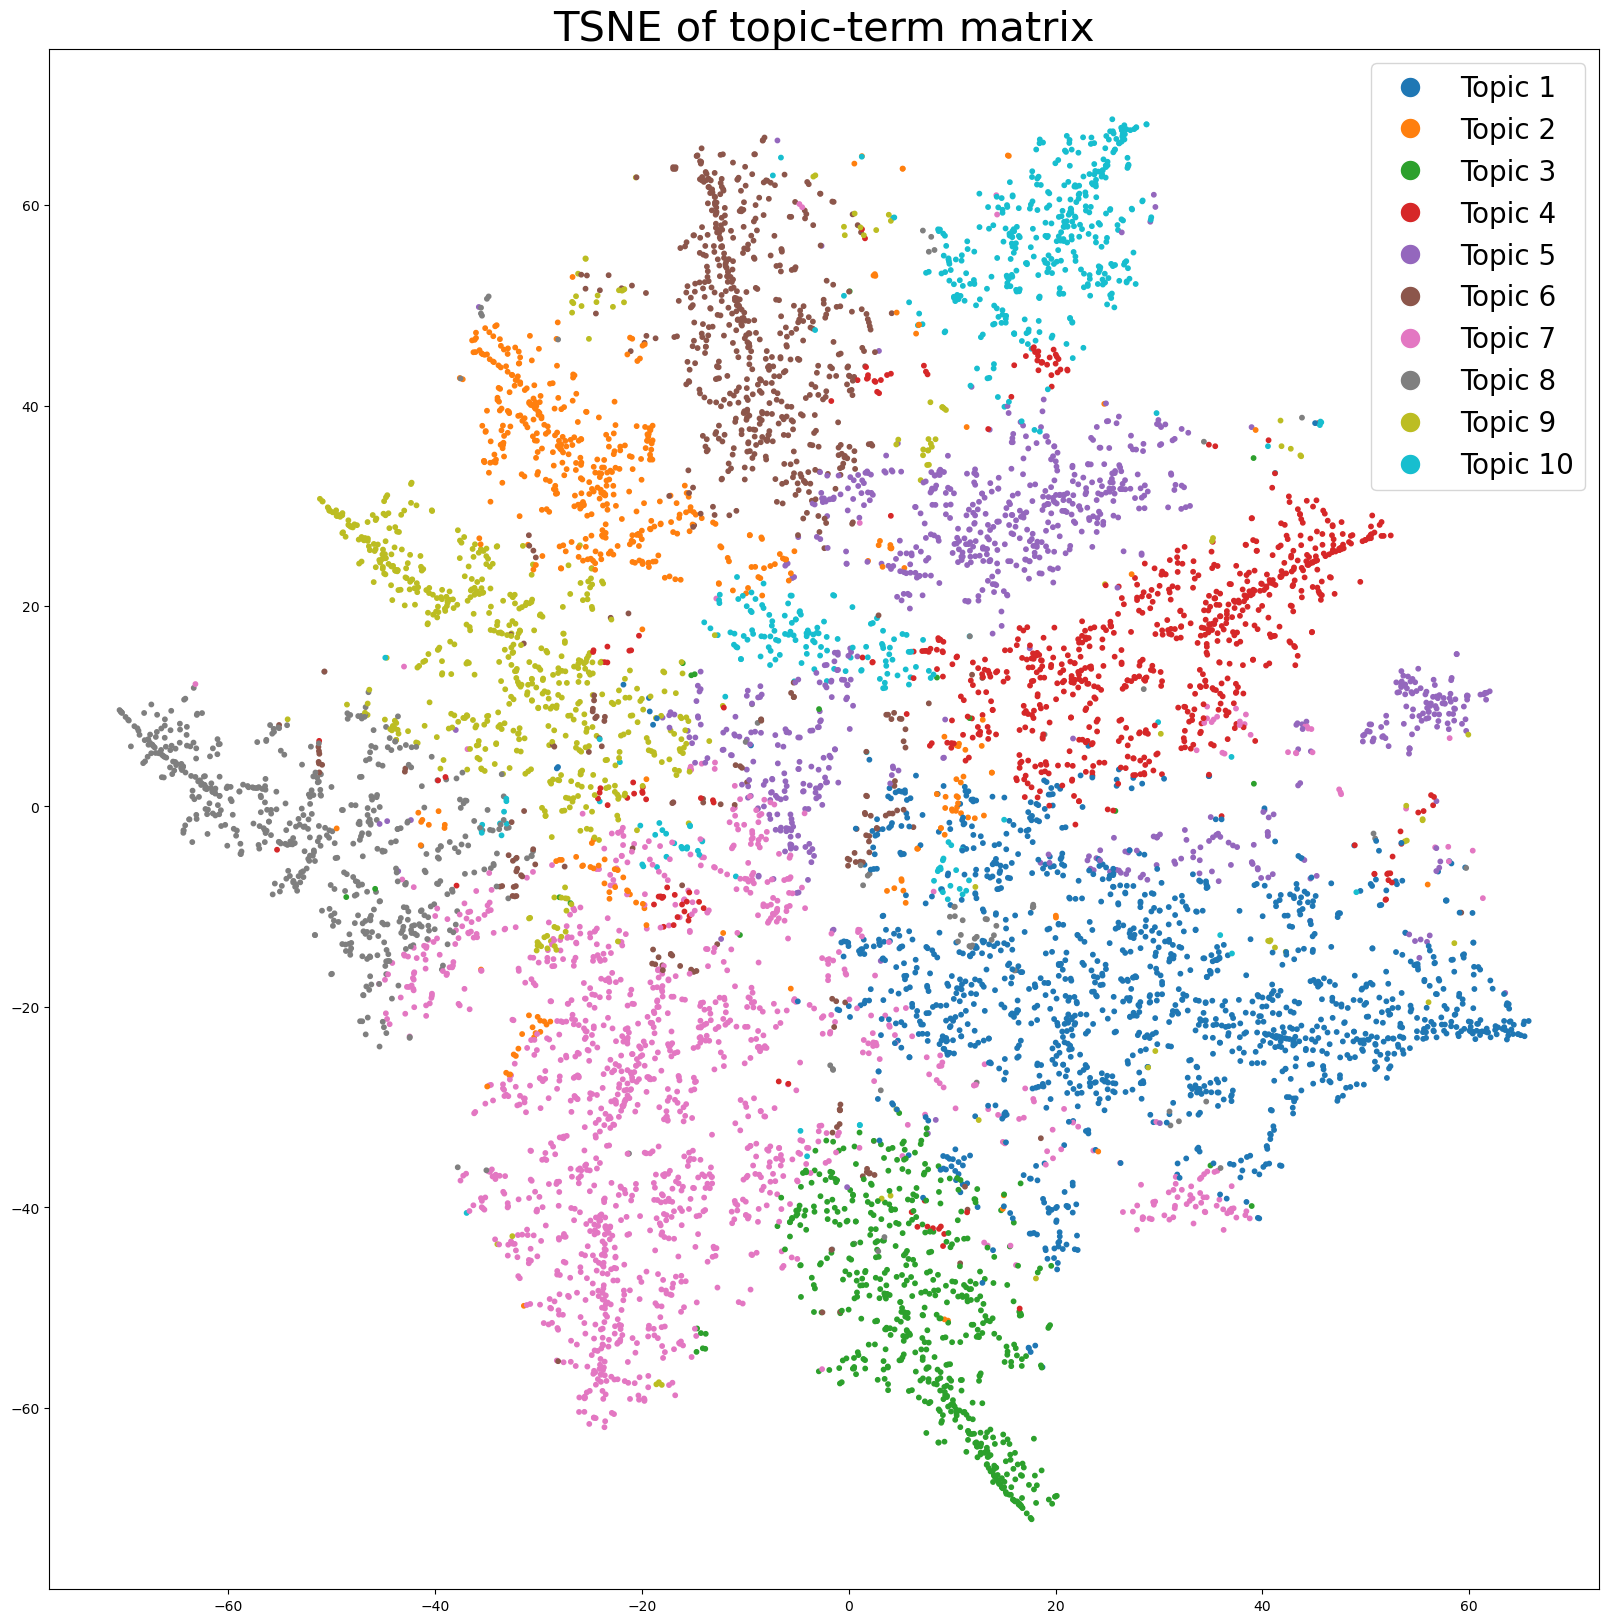

In [60]:
# fix for zero-indexing
tsne_df["topic"] = tsne_df["topic"] + 1
# plot the tsne
plt.figure(figsize=(20,20))
plt.scatter(tsne_df["x"], tsne_df["y"], s=10, c=tsne_df["topic"], cmap="tab10")

# add a a legend
legend_elements = []
for i in range(n_topics):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f"Topic {i+1}", markerfacecolor=plt.cm.tab10(i), markersize=15))
plt.legend(handles=legend_elements, fontsize=20)
plt.title("TSNE of topic-term matrix", fontsize=30)

plt.show()

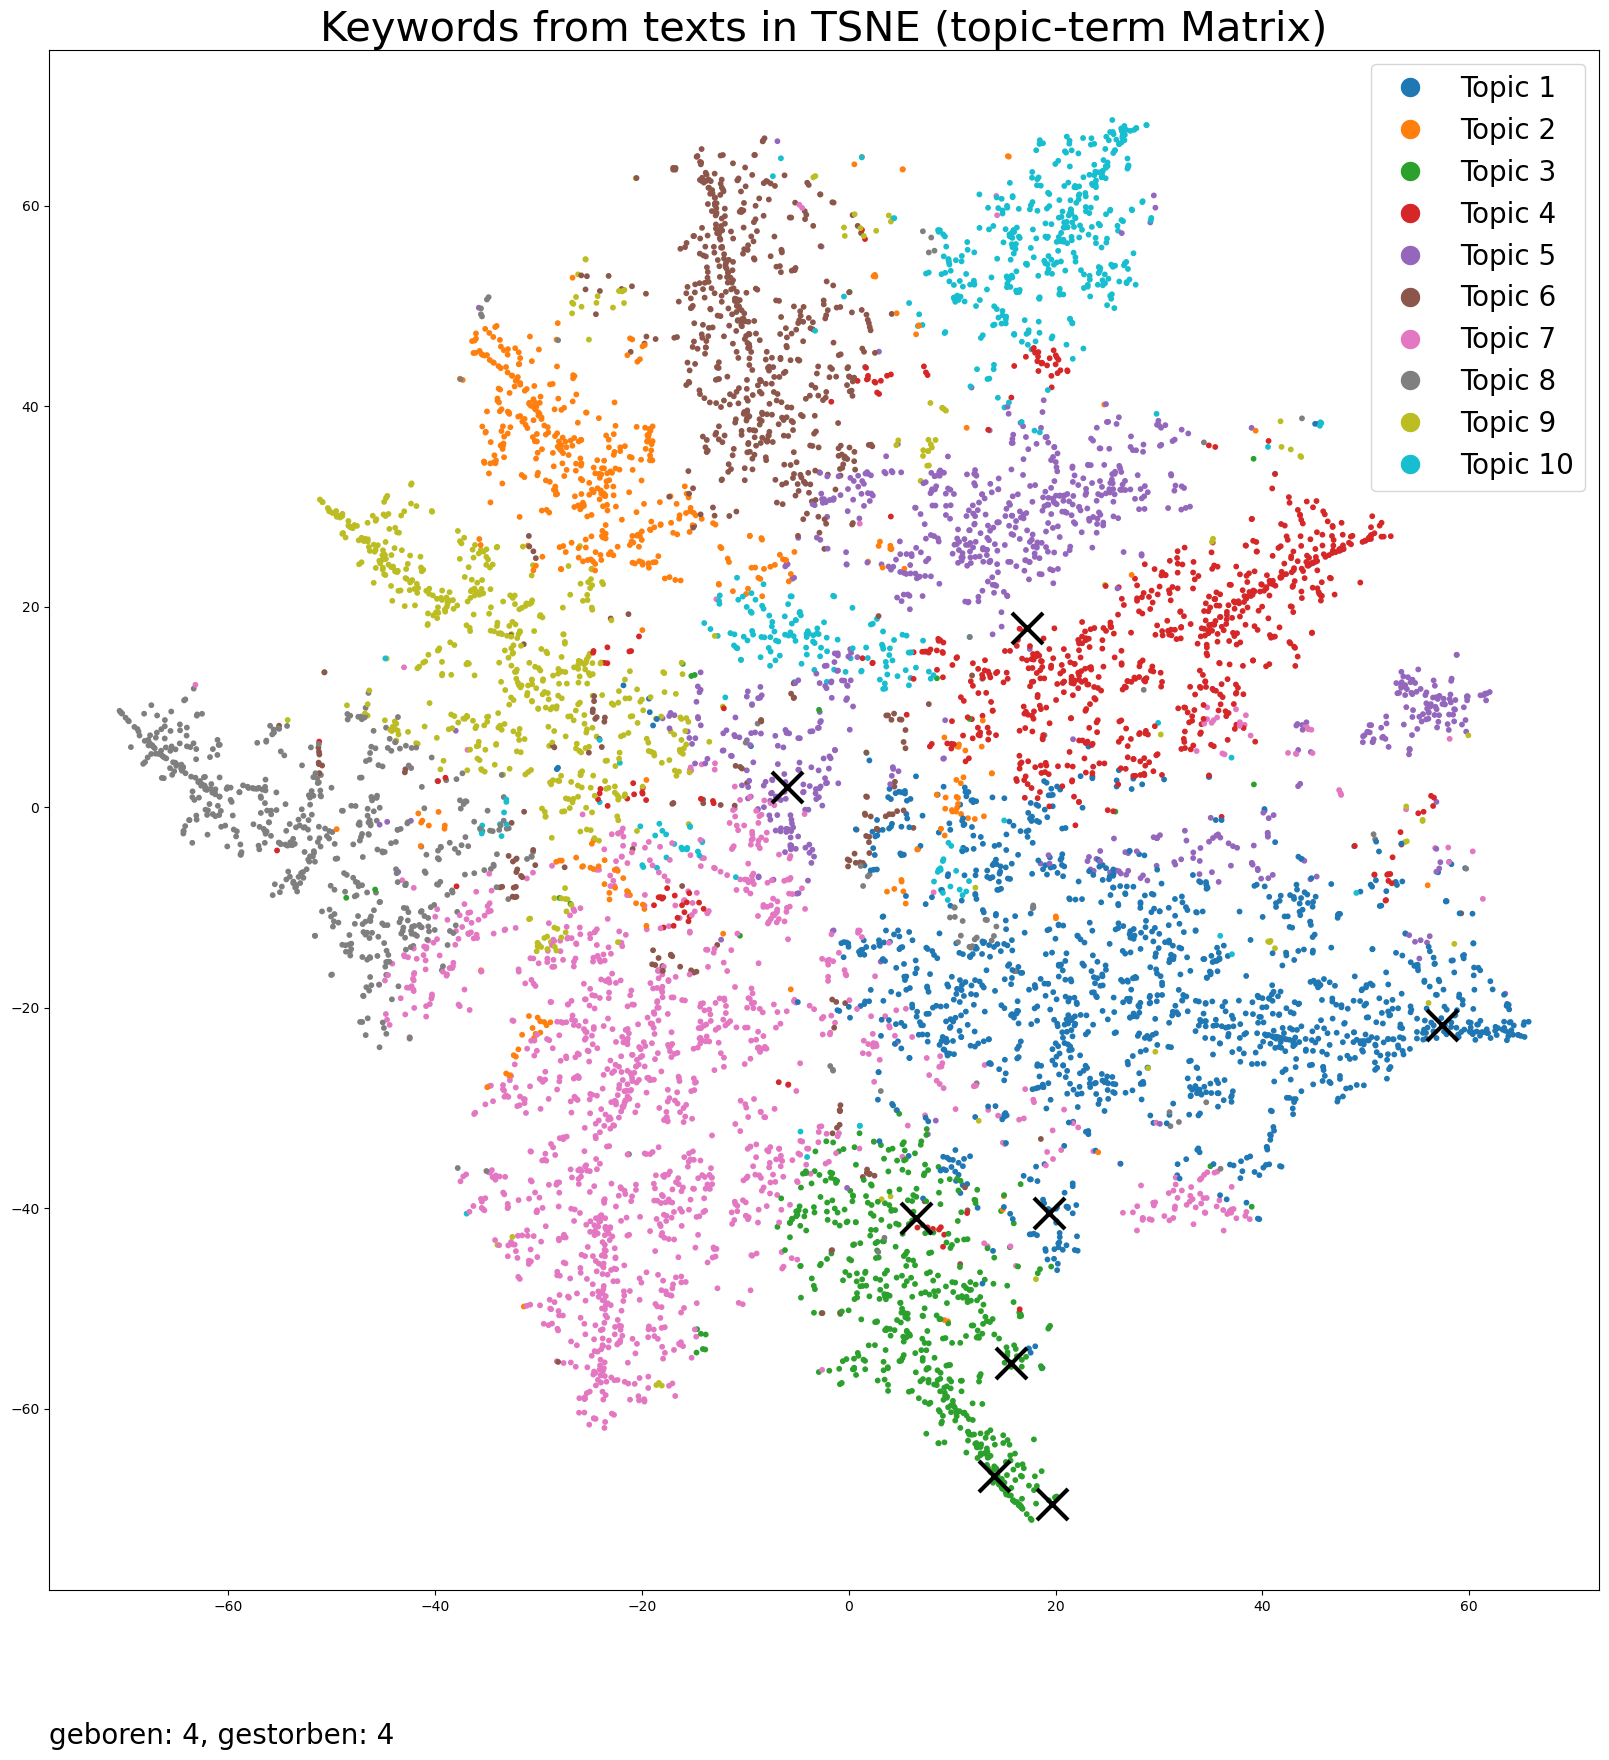

x          y  topic
geboren starb  19.335442 -40.530994      1
gestorben      57.347984 -21.759724      1
geboren        19.663235 -69.577354      3
geboren wien   14.022894 -66.690681      3
gestorbene      6.517632 -40.970829      3
wien geboren   15.700513 -55.421589      3
gestorbenen    17.259501  17.887241      4
ausgestorben   -6.009102   2.041054      5

In [61]:
def plot_keywords_in_tsne_topic_term(keywords, tsne_df, display_df = False):
    """Plot the tsne with the keywords highlighted"""
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(tsne_df["x"], tsne_df["y"], s=10, c=tsne_df["topic"], cmap="tab10")
    ax.set_title("Keywords from texts in TSNE (topic-term Matrix)", fontsize=30)
    legend_elements = []
    for i in range(n_topics):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f"Topic {i+1}", markerfacecolor=plt.cm.tab10(i), markersize=15))
    ax.legend(handles=legend_elements, fontsize=20)
    # add the keywords
    info = []
    for keyword in keywords:
        temp_df = tsne_df[tsne_df.index.str.lower().str.contains(keyword)]
        ax.scatter(temp_df["x"], temp_df["y"], marker="x", label=keyword, s = 500, linewidth=3, c = "black")
        info.append(f"{keyword}: {len(temp_df)}")
    # add text at the bottom
    info_txt = ", ".join(info)
    ax.text(0, -0.1, info_txt, transform=ax.transAxes, fontsize=20)
    plt.show()
    if display_df:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(tsne_df[tsne_df.index.str.lower().str.contains("|".join(x for x in keywords))].sort_values(by="topic"))
    
plot_keywords_in_tsne_topic_term("geboren, gestorben".split(", "), tsne_df, True)

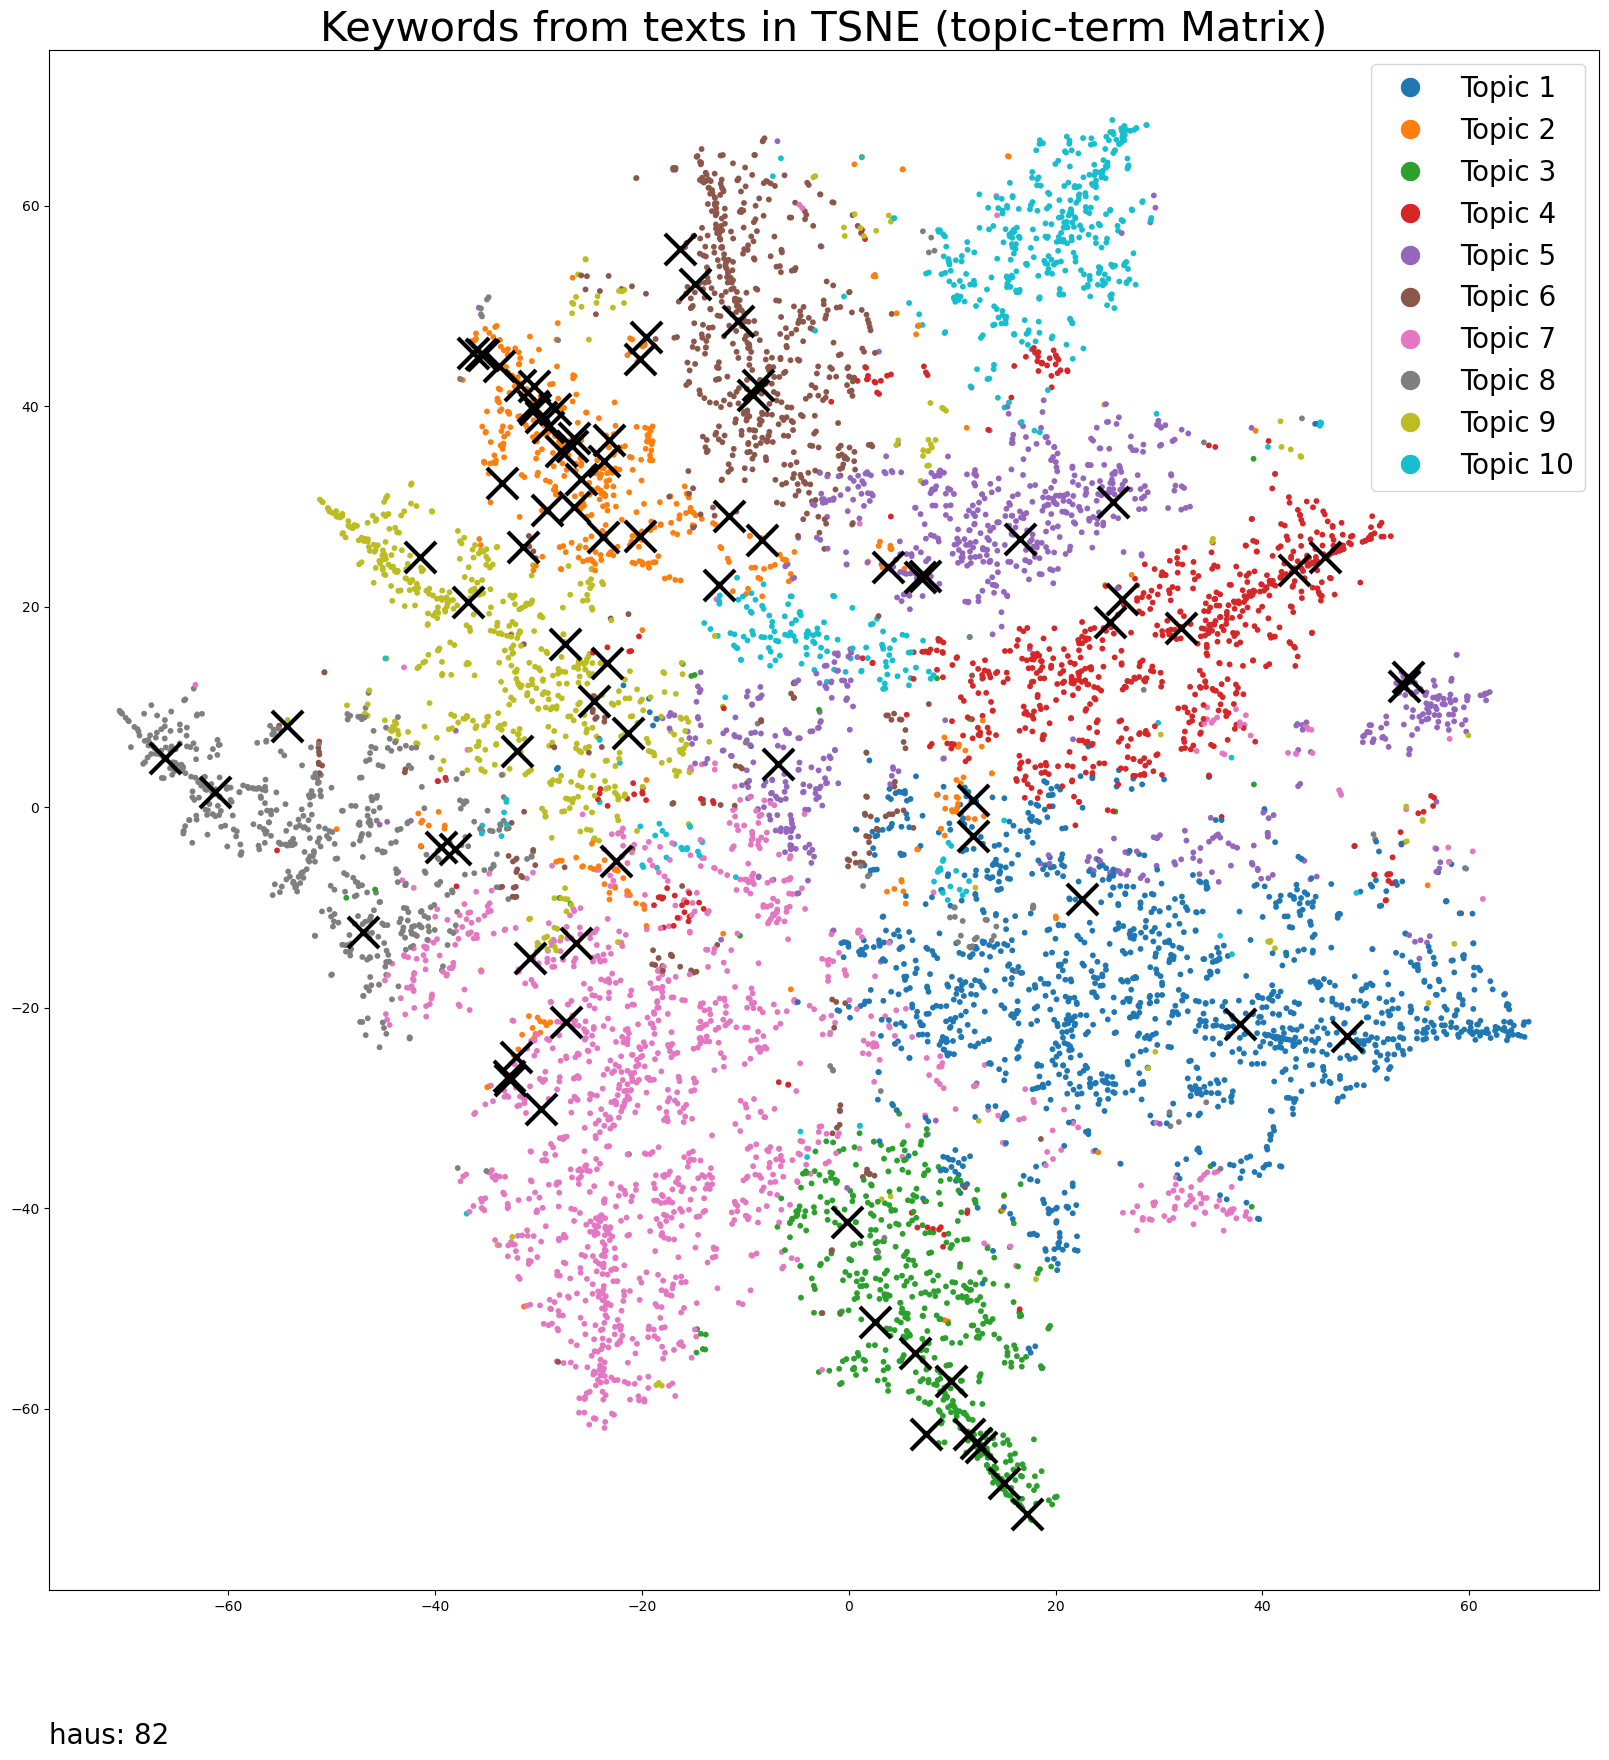

x          y  topic
fürstenhauses               12.014783   0.699280      1
kaiserhauses                48.196125 -22.828720      1
karthause                   12.042469  -2.835990      1
hause babenberg             37.859062 -21.645311      1
richthausen                 22.554043  -9.170180      1
rathhaus                   -30.417358  42.032192      2
namen hauses               -20.199085  27.032757      2
majoratshaus               -26.735725  36.071045      2
liegende haus              -25.920853  32.759579      2
haus                       -36.304131  45.326271      2
haus erhielt               -26.546778  29.957932      2
haus gehört                -30.358803  39.767075      2
zinshaus                   -27.793810  35.577522      2
haus nr                    -31.779510  42.163094      2
hause                      -35.529850  45.230312      2
hause nr                   -23.218182  36.673813      2
hause wohnte               -23.779263  26.917318      2
hauses                     -35.423267  45.134468      2
hauses nr                  -12.565387  22.210260      2
haus goldenen              -29.225691  29.668905      2
landhaus                   -20.202669  44.702282      2
rathhause                   -8.393539  26.699085      2
jn hause                   -29.725407  38.904514      2
amtshause                  -32.203270 -24.891565      2
zeughaus                   -33.510811  32.304253      2
stifthaus                  -28.457949  39.702187      2
eckhaus                    -29.118317  37.925129      2
schen hause                -30.563398  40.081863      2
besitzer hauses            -26.556307  36.844933      2
sche haus                  -33.880676  44.015537      2
bierhaus                   -32.821247 -26.828840      2
rathhauses                 -23.661478  34.580040      2
hofschauspieler              9.899724 -57.304466      3
schauspielkunst             11.625350 -62.548298      3
schauspielhaus               2.539851 -51.380810      3
schauspielers                6.424591 -54.472351      3
schauspielerin              12.746848 -63.839287      3
schauspieler                17.206903 -70.537788      3
schauspiele                 12.335597 -63.446106      3
freihause                   -0.220228 -41.419117      3
schauspiel                  15.051101 -67.385994      3
schauspiels                  7.494648 -62.512943      3
krankenhause                46.093922  24.981632      4
krankenhaus                 25.297081  18.438663      4
waisenhaus                  26.402355  20.799080      4
krankenhauses               32.130043  17.915781      4
allgemeinen krankenhause    43.026585  23.655333      4
jnvalidenhaus              -23.350885  14.371462      4
hauscapelle                  7.377061  23.073208      5
haus großen                  3.836030  24.018898      5
landhause                   -6.866154   4.299614      5
gotteshauses                25.583786  30.482779      5
gotteshause                 53.693111  12.088759      5
gotteshaus                  54.078148  12.972028      5
ordenshauses                16.532566  26.769304      5
freihauses                   6.852320  23.016954      5
gasthaus                   -19.575779  46.965279      6
bethaus                    -11.556537  29.058947      6
brauhaus                    -8.794711  42.098480      6
bräuhaus                   -16.292168  55.724514      6
wirthshause                -10.748651  48.541687      6
fünfhaus                   -24.637665  10.582885      6
badhaus                     -9.288545  41.132450      6
wirthshaus                 -14.862524  52.172577      6
gasthause                  -30.796766 -15.069000      7
gasthauses                 -22.516924  -5.383752      7
bräuhause                  -26.372765 -13.584390      7
amtshause rauhensteingasse -27.330811 -21.457031      7
hausfrau                   -32.780651 -27.243963      7
behausung                  -29.814096 -30.101135      7
wohnhaus                   -39.473515  -3.948989      8
caff

In [62]:
plot_keywords_in_tsne_topic_term(["haus"], tsne_df, True)

In [63]:
tsne_df.reset_index(inplace=True)

In [112]:
import plotly.graph_objects as go

color_sequence = {1: "blue", 2: "orange", 3: "green", 4: "red", 5: "purple", 6: "brown", 7: "pink", 8: "grey", 9: "darkkhaki", 10: "cyan"}
tsne_df["topic_name"] = tsne_df["topic"].map(topic_mapping)
topic_mapping = {1: "Courtly matters", 2: "Buildings", 3: "Culture", 4: "Culture / Theater?", 5: "Religion",
                6: "Suburbia", 7: "Entertainment?", 8: "Military? Bastions?", 9: "Suburbia", 10: "Paintigs (Art)"}

fig = go.Figure()

for topic_val, color in color_sequence.items():
    topic_df = tsne_df[tsne_df['topic'] == topic_val]
    fig.add_trace(go.Scatter(
        x=topic_df['x'],
        y=topic_df['y'],
        mode='markers',
        marker=dict(color=color),
        name = f"Topic {topic_val} - {topic_mapping[topic_val]}",
        text=topic_df["index"] + "<br>" + "Topic:" + topic_df["topic_name"],
        hoverinfo="text"
    ))

fig.update_layout(
    title='TSNE of documents x topics',
    title_x=0.5,
    showlegend=True
)

fig.show()

fig.write_html("../output/tsne_plotly_keywords_x_topic.html")